# Question 1 - Fight outcome prediction

Import necessary libraries and create global variables

In [114]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, classification_report
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV
import warnings
import os
# Ignore warnings
warnings.filterwarnings("ignore")
sns.set(style='whitegrid')


base_folder_path = "datasets/"  

#intermediate_steps_folder = 'dataset/Intermediate_datasets_Q1/'
#os.makedirs(intermediate_steps_folder, exist_ok=True) # this is in case we create 
# set up for printing whole dataframes
pd.set_option("display.max_columns", None)
#pd.set_option("display.max_rows", None)

#### Read data

First dataset

In [115]:
df_fight_stats = pd.read_csv(base_folder_path + 'merged_stats_n_scorecards.csv', sep=';')
df_fighter_stats = pd.read_csv(base_folder_path + "fighter_stats.csv")

In [116]:
df_fight_stats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2143 entries, 0 to 2142
Data columns (total 61 columns):
 #   Column                             Non-Null Count  Dtype 
---  ------                             --------------  ----- 
 0   red_fighter_name                   2143 non-null   object
 1   blue_fighter_name                  2143 non-null   object
 2   event_date                         2143 non-null   object
 3   red_fighter_nickname               2143 non-null   object
 4   blue_fighter_nickname              2143 non-null   object
 5   red_fighter_result                 2143 non-null   object
 6   blue_fighter_result                2143 non-null   object
 7   method                             2143 non-null   object
 8   round                              2143 non-null   int64 
 9   time                               2143 non-null   object
 10  time_format                        2143 non-null   object
 11  referee                            2143 non-null   object
 12  detail

In [117]:
df_fight_stats.head(5)

red_fighter_name blue_fighter_name  event_date red_fighter_nickname  \
0      ILIA TOPURIA      MAX HOLLOWAY  26/10/2024           El Matador   
1  ROBERT WHITTAKER   KHAMZAT CHIMAEV  26/10/2024           The Reaper   
2  MAGOMED ANKALAEV  ALEKSANDAR RAKIC  26/10/2024                    -   
3     LERONE MURPHY           DAN IGE  26/10/2024          The Miracle   
4   SHARA MAGOMEDOV   ARMEN PETROSYAN  26/10/2024               Bullet   

  blue_fighter_nickname red_fighter_result blue_fighter_result  \
0               Blessed                  W                   L   
1                  Borz                  L                   W   
2                Rocket                  W                   L   
3                   50K                  W                   L   
4              Superman                  W                   L   

                 method  round  time        time_format        referee  \
0                KO/TKO      3  1:34  5 Rnd (5-5-5-5-5)   Marc Goddard   
1            Submission      1  3:34  5 Rnd (5-5-5-5-5)   Jason Herzog   
2  Decision - Unanimous      3  5:00      3 Rnd (5-5-5)  Vitor Ribeiro   
3  Decision - Unanimous      3  5:00      3 Rnd (5-5-5)     Mark Smith   
4                KO/TKO      2  4:52      3 Rnd (5-5-5)   Kerry Hatley   

                                             details  \
0                          Punch to Head At Distance   
1                                   Rear Naked Choke   
2  Sal D'amato 28 - 29. Jacob Montalvo 28 - 29. T...   
3  Mike Bell 28 - 29. Ben Cartlidge 28 - 29. Hadi...   
4                            Spinning Back Fist Head   

                      bout_type bonus                     event_name  \
0  UFC Featherweight Title Bout  belt  UFC 308: Topuria vs. Holloway   
1             Middleweight Bout  perf  UFC 308: Topuria vs. Holloway   
2        Light Heavyweight Bout     -  UFC 308: Topuria vs. Holloway   
3            Featherweight Bout     -  UFC 308: Topuria vs. Holloway   
4             Middleweight Bout  perf  UFC 308: Topuria vs. Holloway   

                               event_location  red_fighter_KD  \
0  Abu Dhabi, Abu Dhabi, United Arab Emirates               1   
1  Abu Dhabi, Abu Dhabi, United Arab Emirates               0   
2  Abu Dhabi, Abu Dhabi, United Arab Emirates               0   
3  Abu Dhabi, Abu Dhabi, United Arab Emirates               0   
4  Abu Dhabi, Abu Dhabi, United Arab Emirates               1   

   blue_fighter_KD red_fighter_sig_str blue_fighter_sig_str  \
0                0           75 of 144            79 of 204   
1                0              2 of 2               3 of 4   
2                0           55 of 114            53 of 117   
3                1           52 of 100            46 of 106   
4                0           65 of 106            77 of 140   

  red_fighter_sig_str_pct blue_fighter_sig_str_pct red_fighter_total_str  \
0                      52                       38             78 of 147   
1                     100                       75                2 of 2   
2                      48                       45             75 of 142   
3                      52                       43             78 of 133   
4                      61                       55             67 of 108   

  blue_fighter_total_str red_fighter_TD blue_fighter_TD red_fighter_TD_pct  \
0              84 of 209         2 of 2          0 of 0                100   
1               25 of 31         0 of 0          2 of 4                ---   
2              59 of 123         0 of 0          0 of 1                ---   
3              52 of 116         3 of 5          1 of 3                 60   
4              77 of 141         0 of 0          0 of 0                ---   

  blue_fighter_TD_pct  red_fighter_sub_att  blue_fighter_sub_att  \
0                 ---                    0                     0   
1                  50                    0                     1   
2                   0                    0    

Second dataset

In [118]:
df_fighter_stats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4111 entries, 0 to 4110
Data columns (total 18 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   name                                          4111 non-null   object 
 1   nickname                                      2257 non-null   object 
 2   wins                                          4111 non-null   int64  
 3   losses                                        4111 non-null   int64  
 4   draws                                         4111 non-null   int64  
 5   height_cm                                     3813 non-null   float64
 6   weight_in_kg                                  4024 non-null   float64
 7   reach_in_cm                                   2184 non-null   float64
 8   stance                                        3288 non-null   object 
 9   date_of_birth                                 2976 non-null   o

In [119]:
df_fighter_stats.head()

name    nickname  wins  losses  draws  height_cm  \
0    Robert Drysdale         NaN     7       0      0     190.50   
1  Daniel McWilliams  The Animal    15      37      0     185.42   
2         Dan Molina         NaN    13       9      0     177.80   
3          Paul Ruiz         NaN     7       4      0     167.64   
4    Collin Huckbody      All In     8       2      0     190.50   

   weight_in_kg  reach_in_cm    stance date_of_birth  \
0         92.99          NaN  Orthodox    1981-10-05   
1         83.91          NaN       NaN           NaN   
2         97.98          NaN       NaN           NaN   
3         61.23          NaN       NaN           NaN   
4         83.91       193.04  Orthodox    1994-09-29   

   significant_strikes_landed_per_minute  significant_striking_accuracy  \
0                                   0.00                            0.0   
1                                   3.36                           77.0   
2                                   0.00                            0.0   
3                                   1.40                           33.0   
4                                   2.05                           60.0   

   significant_strikes_absorbed_per_minute  significant_strike_defence  \
0                                     0.00                         0.0   
1                                     0.00                         0.0   
2                                     5.58                        60.0   
3                                     1.40                        75.0   
4                                     2.73                        42.0   

   average_takedowns_landed_per_15_minutes  takedown_accuracy  \
0                                     7.32              100.0   
1                                     0.00                0.0   
2                                     0.00                0.0   
3                                     0.00                0.0   
4                                    10.23              100.0   

   takedown_defense  average_submissions_attempted_per_15_minutes  
0               0.0                                          21.9  
1             100.0                                          21.6  
2               0.0                                          20.9  
3             100.0                                          20.9  
4               0.0                                          20.4

We need to merge these 2 datasets, using the fighters' names. Why? Because we would like to predict the results of the fights. Firstly, we will check if we have all red fighters and after that we will check if we have all blue fighters

In [120]:
df_fighter_stats['name'] = df_fighter_stats['name'].str.upper()
df_fight_stats['red_fighter_name'] = df_fight_stats['red_fighter_name'].str.upper()
df_fight_stats['blue_fighter_name'] = df_fight_stats['blue_fighter_name'].str.upper()


# Merge statistics for red fighters
red_fighter_stats = df_fight_stats.merge(
    df_fighter_stats.add_prefix('red_'), 
    left_on='red_fighter_name', 
    right_on='red_name', 
    how='left'
)

# Merge statistics for blue fighters
merged_fighter_stats = red_fighter_stats.merge(
    df_fighter_stats.add_prefix('blue_'), 
    left_on='blue_fighter_name', 
    right_on='blue_name', 
    how='left'
)

merged_fighter_stats = merged_fighter_stats.drop(columns=['red_name', 'blue_name'])
#merged_fighter_stats.to_csv("Complete_merge.csv")


Probably, some fighters are missing or they were not recognized. We will extract them

In [121]:
# Extract fighters with missing values from merged data
missing_values_red = merged_fighter_stats[merged_fighter_stats.filter(like='red_').isnull().any(axis=1)]
missing_values_blue = merged_fighter_stats[merged_fighter_stats.filter(like='blue_').isnull().any(axis=1)]

missing_values_blue = missing_values_blue[['blue_fighter_name']].drop_duplicates()
missing_values_red = missing_values_red[['red_fighter_name']].drop_duplicates()


In [122]:
missing_values_red

red_fighter_name
2     MAGOMED ANKALAEV
7      MATEUSZ REBECKI
8       ABUS MAGOMEDOV
15            ROB FONT
19     MATHEUS NICOLAU
...                ...
2075     CHRIS DAUKAUS
2090      CASEY KENNEY
2102  KHADIS IBRAGIMOV
2109     MIRSAD BEKTIC
2144    MALLORY MARTIN

[248 rows x 1 columns]

In [123]:
missing_values_blue

blue_fighter_name
2     ALEKSANDAR RAKIC
5     RAFAEL CERQUEIRA
6     RAFAEL DOS ANJOS
7     MYKTYBEK OROLBAI
13         CARLOS LEAL
...                ...
2129     ZELIM IMADAEV
2134      HUNTER AZURE
2140      ZAK CUMMINGS
2141   AUSTIN SPRINGER
2150            MIZUKI

[274 rows x 1 columns]

#### For column explanation

## EDA analysis and data preparation.

### Data transformation

Firstly, we will create target features, which will define who won the match. We will introduce new target feature, "who_wins". In case that Red fighter won, we will endoce it with "Red" in case that "Blue" fighter won, we will introduce "Blue". In our dataset, there is no Draw and it is very rare in real scenarios, but in our code we will introduce that third category "Draw"

In [124]:
def create_target_feature(row):
    if(row["blue_fighter_result"] == 'W'):
        return "Blue"
    elif(row["red_fighter_result"] == 'W'):
        return "Red"
    else:
        return "Draw"
    
# apply this function and create target column
merged_fighter_stats['who_wins'] = merged_fighter_stats.apply(create_target_feature, axis=1) 

# we need to drop existing red_fighter_result and blue_fighter_result
merged_fighter_stats = merged_fighter_stats.drop(columns=['red_fighter_result', 'blue_fighter_result'])

merged_fighter_stats.head(5)

red_fighter_name blue_fighter_name  event_date red_fighter_nickname  \
0      ILIA TOPURIA      MAX HOLLOWAY  26/10/2024           El Matador   
1  ROBERT WHITTAKER   KHAMZAT CHIMAEV  26/10/2024           The Reaper   
2  MAGOMED ANKALAEV  ALEKSANDAR RAKIC  26/10/2024                    -   
3     LERONE MURPHY           DAN IGE  26/10/2024          The Miracle   
4   SHARA MAGOMEDOV   ARMEN PETROSYAN  26/10/2024               Bullet   

  blue_fighter_nickname                method  round  time        time_format  \
0               Blessed                KO/TKO      3  1:34  5 Rnd (5-5-5-5-5)   
1                  Borz            Submission      1  3:34  5 Rnd (5-5-5-5-5)   
2                Rocket  Decision - Unanimous      3  5:00      3 Rnd (5-5-5)   
3                   50K  Decision - Unanimous      3  5:00      3 Rnd (5-5-5)   
4              Superman                KO/TKO      2  4:52      3 Rnd (5-5-5)   

         referee                                            details  \
0   Marc Goddard                          Punch to Head At Distance   
1   Jason Herzog                                   Rear Naked Choke   
2  Vitor Ribeiro  Sal D'amato 28 - 29. Jacob Montalvo 28 - 29. T...   
3     Mark Smith  Mike Bell 28 - 29. Ben Cartlidge 28 - 29. Hadi...   
4   Kerry Hatley                            Spinning Back Fist Head   

                      bout_type bonus                     event_name  \
0  UFC Featherweight Title Bout  belt  UFC 308: Topuria vs. Holloway   
1             Middleweight Bout  perf  UFC 308: Topuria vs. Holloway   
2        Light Heavyweight Bout     -  UFC 308: Topuria vs. Holloway   
3            Featherweight Bout     -  UFC 308: Topuria vs. Holloway   
4             Middleweight Bout  perf  UFC 308: Topuria vs. Holloway   

                               event_location  red_fighter_KD  \
0  Abu Dhabi, Abu Dhabi, United Arab Emirates               1   
1  Abu Dhabi, Abu Dhabi, United Arab Emirates               0   
2  Abu Dhabi, Abu Dhabi, United Arab Emirates               0   
3  Abu Dhabi, Abu Dhabi, United Arab Emirates               0   
4  Abu Dhabi, Abu Dhabi, United Arab Emirates               1   

   blue_fighter_KD red_fighter_sig_str blue_fighter_sig_str  \
0                0           75 of 144            79 of 204   
1                0              2 of 2               3 of 4   
2                0           55 of 114            53 of 117   
3                1           52 of 100            46 of 106   
4                0           65 of 106            77 of 140   

  red_fighter_sig_str_pct blue_fighter_sig_str_pct red_fighter_total_str  \
0                      52                       38             78 of 147   
1                     100                       75                2 of 2   
2                      48                       45             75 of 142   
3                      52                       43             78 of 133   
4                      61                       55             67 of 108   

  blue_fighter_total_str red_fighter_TD blue_fighter_TD red_fighter_TD_pct  \
0              84 of 209         2 of 2          0 of 0                100   
1               25 of 31         0 of 0          2 of 4                ---   
2              59 of 123         0 of 0          0 of 1                ---   
3              52 of 116         3 of 5          1 of 3                 60   
4              77 of 141         0 of 0          0 of 0                ---   

  blue_fighter_TD_pct  red_fighter_sub_att  blue_fighter_sub_att  \
0                 ---                    0                     0   
1                  50                    0                     1   
2                   0                    0                     0   
3                  33                    0                     0   
4                 ---                    0                     0   

   red_fighter_rev  blue_fighter_rev red_fighter_ctrl blue_fighter_ctrl  \
0                0             

### Features explanation

Fighter Identification
1. red_fighter_name, blue_fighter_name: Names of the red and blue fighters.
2. red_nickname, blue_nickname: Fighter nicknames 
   
Match Metadata
1. event_date: Date of the match.
2. method: How the match ended (e.g., knockout, decision, submission).
3. round: The round in which the fight ended.
4. bout_type: Type of bout (e.g., main event, undercard).
5. bonus: Whether bonuses were awarded for performance.

Performance Metrics
1. Knockdowns (KD):
   - red_fighter_KD, blue_fighter_KD: Knockdowns delivered by each fighter.

2. Significant Strikes (Sig Str):
   - red_fighter_sig_str, blue_fighter_sig_str: Total significant strikes landed.
   - red_fighter_sig_str_pct, blue_fighter_sig_str_pct: Strike accuracy percentage.
   - Detailed strikes (head, body, leg, distance, clinch, ground).

3. Takedowns (TD):
   - red_fighter_TD, blue_fighter_TD: Total takedowns landed.
   - red_fighter_TD_pct, `blue_fighter_TD_pct: Takedown accuracy percentage.

4. Control Metrics:
   - red_fighter_ctrl, blue_fighter_ctrl: Time spent controlling the opponent.
   - red_fighter_sub_att, blue_fighter_sub_att: Submission attempts.
   - red_fighter_rev, blue_fighter_rev: Reversals.

5. Points:
   - red_fighter_total_pts, blue_fighter_total_pts: Points scored.

Physical Attributes
1. Height: red_height_cm, blue_height_cm.
2. Weight: red_weight_in_kg, blue_weight_in_kg.
3. Reach: red_reach_in_cm, blue_reach_in_cm.
4. Stance: red_stance, blue_stance (e.g., orthodox, southpaw).

Career Statistics
1. Wins/Losses/Draws:
   - red_wins, blue_wins: Career wins.
   - red_losses, blue_losses: Career losses.
   - red_draws, blue_draws: Career draws.

2. Striking Metrics:
   - red_significant_strikes_landed_per_minute, blue_significant_strikes_landed_per_minute: Strikes landed per minute.
   - red_significant_striking_accuracy, blue_significant_striking_accuracy: Accuracy.
   - red_significant_strikes_absorbed_per_minute, blue_significant_strikes_absorbed_per_minute: Strikes absorbed.

3. Defense Metrics:
   - red_significant_strike_defence, blue_significant_strike_defence: Percentage of strikes defended.
   - red_takedown_defense, blue_takedown_defense: Takedown defense percentage.

4. Takedowns and Submissions:
   - red_average_takedowns_landed_per_15_minutes, blue_average_takedowns_landed_per_15_minutes: Takedowns per 15 minutes.
   - red_average_submissions_attempted_per_15_minutes, blue_average_submissions_attempted_per_15_minutes: Submission attempts.

Outcome
1. who_wins: Target feature (Red, Blue, or Draw).


#### Remove irrelevant features

For the analysis, there are some feature that are completely irrelevant for prediction, such as nicknames of the fighters, etc... We will remove them. Complete list:
- event_date, 
- red_fighter_nickname,
- blue_fighter_nickname, 
- time_format, 
- referee, 
- details, 
- event_name,
- event_location, 
- red_nickname, 
- red_stance, 
- blue_nickname, 
- blue_stance


In [125]:
merged_fighter_stats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2164 entries, 0 to 2163
Data columns (total 94 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   red_fighter_name                                   2164 non-null   object 
 1   blue_fighter_name                                  2164 non-null   object 
 2   event_date                                         2164 non-null   object 
 3   red_fighter_nickname                               2164 non-null   object 
 4   blue_fighter_nickname                              2164 non-null   object 
 5   method                                             2164 non-null   object 
 6   round                                              2164 non-null   int64  
 7   time                                               2164 non-null   object 
 8   time_format                                        2164 non-null   object 
 9   referee 

In [126]:
columns_to_drop = ['event_date', 'red_fighter_nickname', 'blue_fighter_nickname', 'time_format', 'referee', 'details', 'event_name',
                   'event_location', 'red_nickname', 'red_stance', 'blue_nickname', 'blue_stance']

merged_fighter_stats = merged_fighter_stats.drop(columns=columns_to_drop)

merged_fighter_stats.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2164 entries, 0 to 2163
Data columns (total 82 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   red_fighter_name                                   2164 non-null   object 
 1   blue_fighter_name                                  2164 non-null   object 
 2   method                                             2164 non-null   object 
 3   round                                              2164 non-null   int64  
 4   time                                               2164 non-null   object 
 5   bout_type                                          2164 non-null   object 
 6   bonus                                              2164 non-null   object 
 7   red_fighter_KD                                     2164 non-null   int64  
 8   blue_fighter_KD                                    2164 non-null   int64  
 9   red_figh

In [127]:
display(merged_fighter_stats)

red_fighter_name blue_fighter_name                method  round  time  \
0         ILIA TOPURIA      MAX HOLLOWAY                KO/TKO      3  1:34   
1     ROBERT WHITTAKER   KHAMZAT CHIMAEV            Submission      1  3:34   
2     MAGOMED ANKALAEV  ALEKSANDAR RAKIC  Decision - Unanimous      3  5:00   
3        LERONE MURPHY           DAN IGE  Decision - Unanimous      3  5:00   
4      SHARA MAGOMEDOV   ARMEN PETROSYAN                KO/TKO      2  4:52   
...                ...               ...                   ...    ...   ...   
2159     FELICE HERRIG   VIRNA JANDIROBA            Submission      1  1:44   
2160          TJ BROWN      DANNY CHAVEZ  Decision - Unanimous      3  5:00   
2161      ASHLEY YODER     LIVINHA SOUZA  Decision - Unanimous      3  5:00   
2162     CHRIS DAUKAUS     PARKER PORTER                KO/TKO      1  4:28   
2163        KAI KAMAKA       TONY KELLEY  Decision - Unanimous      3  5:00   

                         bout_type  bonus  red_fighter_KD  blue_fighter_KD  \
0     UFC Featherweight Title Bout   belt               1                0   
1                Middleweight Bout   perf               0                0   
2           Light Heavyweight Bout      -               0                0   
3               Featherweight Bout      -               0                1   
4                Middleweight Bout   perf               1                0   
...                            ...    ...             ...              ...   
2159      Women's Strawweight Bout   perf               0                0   
2160            Featherweight Bout      -               0                0   
2161      Women's Strawweight Bout      -               0                0   
2162              Heavyweight Bout      -               2                0   
2163            Featherweight Bout  fight               0                0   

     red_fighter_sig_str blue_fighter_sig_str red_fighter_sig_str_pct  \
0              75 of 144            79 of 204                      52   
1                 2 of 2               3 of 4                     100   
2              55 of 114            53 of 117                      48   
3              52 of 100            46 of 106                      52   
4              65 of 106            77 of 140                      61   
...                  ...                  ...                     ...   
2159              1 of 1               4 of 5                     100   
2160           43 of 139            49 of 110                      30   
2161           32 of 114             46 of 70                      28   
2162            37 of 59             17 of 52                      62   
2163          114 of 185           114 of 226                      61   

     blue_fighter_sig_str_pct red_fighter_total_str blue_fighter_total_str  \
0                          38             78 of 147              84 of 209   
1                          75                2 of 2               25 of 31   
2                          45             75 of 142              59 of 123   
3                          43             78 of 133              52 of 116   
4                          55             67 of 108              77 of 141   
...                       ...                   ...                    ...   
2159                       80                3 of 3               12 of 15   
2160                       44             59 of 156              52 of 113   
2161                       65             89 of 176               70 of 95   
2162                       32              45 of 67               18 of 53   
2163                       50            138 of 216             185 of 298   

     red_fighter_TD blue_fighter_TD red_fighter_TD_pct blue_fighter_TD_pct  \
0            2 of 2          0 of 0                100                 ---   
1            0 of 0          2 of 4                ---                  50   
2            0 of 0          0 of 1                ---                  

In this dataset, there are values -, --- or - - - which represents the missing values in the dataset. We will replace with NaN, to avoid any confusion

In [128]:
merged_fighter_stats = merged_fighter_stats.replace(['-', '---', '- - -'], np.nan)

# check if there still exists values with --- and -
null_like_values = (merged_fighter_stats == '---').sum().sum() + (merged_fighter_stats == '-').sum().sum()
print(null_like_values)

0


In [129]:
merged_fighter_stats

red_fighter_name blue_fighter_name                method  round  time  \
0         ILIA TOPURIA      MAX HOLLOWAY                KO/TKO      3  1:34   
1     ROBERT WHITTAKER   KHAMZAT CHIMAEV            Submission      1  3:34   
2     MAGOMED ANKALAEV  ALEKSANDAR RAKIC  Decision - Unanimous      3  5:00   
3        LERONE MURPHY           DAN IGE  Decision - Unanimous      3  5:00   
4      SHARA MAGOMEDOV   ARMEN PETROSYAN                KO/TKO      2  4:52   
...                ...               ...                   ...    ...   ...   
2159     FELICE HERRIG   VIRNA JANDIROBA            Submission      1  1:44   
2160          TJ BROWN      DANNY CHAVEZ  Decision - Unanimous      3  5:00   
2161      ASHLEY YODER     LIVINHA SOUZA  Decision - Unanimous      3  5:00   
2162     CHRIS DAUKAUS     PARKER PORTER                KO/TKO      1  4:28   
2163        KAI KAMAKA       TONY KELLEY  Decision - Unanimous      3  5:00   

                         bout_type  bonus  red_fighter_KD  blue_fighter_KD  \
0     UFC Featherweight Title Bout   belt               1                0   
1                Middleweight Bout   perf               0                0   
2           Light Heavyweight Bout    NaN               0                0   
3               Featherweight Bout    NaN               0                1   
4                Middleweight Bout   perf               1                0   
...                            ...    ...             ...              ...   
2159      Women's Strawweight Bout   perf               0                0   
2160            Featherweight Bout    NaN               0                0   
2161      Women's Strawweight Bout    NaN               0                0   
2162              Heavyweight Bout    NaN               2                0   
2163            Featherweight Bout  fight               0                0   

     red_fighter_sig_str blue_fighter_sig_str red_fighter_sig_str_pct  \
0              75 of 144            79 of 204                      52   
1                 2 of 2               3 of 4                     100   
2              55 of 114            53 of 117                      48   
3              52 of 100            46 of 106                      52   
4              65 of 106            77 of 140                      61   
...                  ...                  ...                     ...   
2159              1 of 1               4 of 5                     100   
2160           43 of 139            49 of 110                      30   
2161           32 of 114             46 of 70                      28   
2162            37 of 59             17 of 52                      62   
2163          114 of 185           114 of 226                      61   

     blue_fighter_sig_str_pct red_fighter_total_str blue_fighter_total_str  \
0                          38             78 of 147              84 of 209   
1                          75                2 of 2               25 of 31   
2                          45             75 of 142              59 of 123   
3                          43             78 of 133              52 of 116   
4                          55             67 of 108              77 of 141   
...                       ...                   ...                    ...   
2159                       80                3 of 3               12 of 15   
2160                       44             59 of 156              52 of 113   
2161                       65             89 of 176               70 of 95   
2162                       32              45 of 67               18 of 53   
2163                       50            138 of 216             185 of 298   

     red_fighter_TD blue_fighter_TD red_fighter_TD_pct blue_fighter_TD_pct  \
0            2 of 2          0 of 0                100                 NaN   
1            0 of 0          2 of 4                NaN                  50   
2            0 of 0          0 of 1                NaN                  

Now we will need to apply some transformations for the columns and convert them to numeric feature instead of time feature. Those columns are 'time', 'red_fighter_ctrl', 'blue_fighter_ctrl'

In [130]:
def convert_time_to_seconds(time_str):
    try:
        minutes, seconds = map(int, time_str.split(':'))
        return minutes * 60 + seconds
    except:
        return np.nan  # Handle invalid or missing values

# columns to tranfomr from date to int
time_format_transf_cols = ['time', 'red_fighter_ctrl', 'blue_fighter_ctrl']

# apply conversion
for col in time_format_transf_cols:
    merged_fighter_stats[col] = merged_fighter_stats[col].apply(convert_time_to_seconds)

merged_fighter_stats



red_fighter_name blue_fighter_name                method  round  time  \
0         ILIA TOPURIA      MAX HOLLOWAY                KO/TKO      3    94   
1     ROBERT WHITTAKER   KHAMZAT CHIMAEV            Submission      1   214   
2     MAGOMED ANKALAEV  ALEKSANDAR RAKIC  Decision - Unanimous      3   300   
3        LERONE MURPHY           DAN IGE  Decision - Unanimous      3   300   
4      SHARA MAGOMEDOV   ARMEN PETROSYAN                KO/TKO      2   292   
...                ...               ...                   ...    ...   ...   
2159     FELICE HERRIG   VIRNA JANDIROBA            Submission      1   104   
2160          TJ BROWN      DANNY CHAVEZ  Decision - Unanimous      3   300   
2161      ASHLEY YODER     LIVINHA SOUZA  Decision - Unanimous      3   300   
2162     CHRIS DAUKAUS     PARKER PORTER                KO/TKO      1   268   
2163        KAI KAMAKA       TONY KELLEY  Decision - Unanimous      3   300   

                         bout_type  bonus  red_fighter_KD  blue_fighter_KD  \
0     UFC Featherweight Title Bout   belt               1                0   
1                Middleweight Bout   perf               0                0   
2           Light Heavyweight Bout    NaN               0                0   
3               Featherweight Bout    NaN               0                1   
4                Middleweight Bout   perf               1                0   
...                            ...    ...             ...              ...   
2159      Women's Strawweight Bout   perf               0                0   
2160            Featherweight Bout    NaN               0                0   
2161      Women's Strawweight Bout    NaN               0                0   
2162              Heavyweight Bout    NaN               2                0   
2163            Featherweight Bout  fight               0                0   

     red_fighter_sig_str blue_fighter_sig_str red_fighter_sig_str_pct  \
0              75 of 144            79 of 204                      52   
1                 2 of 2               3 of 4                     100   
2              55 of 114            53 of 117                      48   
3              52 of 100            46 of 106                      52   
4              65 of 106            77 of 140                      61   
...                  ...                  ...                     ...   
2159              1 of 1               4 of 5                     100   
2160           43 of 139            49 of 110                      30   
2161           32 of 114             46 of 70                      28   
2162            37 of 59             17 of 52                      62   
2163          114 of 185           114 of 226                      61   

     blue_fighter_sig_str_pct red_fighter_total_str blue_fighter_total_str  \
0                          38             78 of 147              84 of 209   
1                          75                2 of 2               25 of 31   
2                          45             75 of 142              59 of 123   
3                          43             78 of 133              52 of 116   
4                          55             67 of 108              77 of 141   
...                       ...                   ...                    ...   
2159                       80                3 of 3               12 of 15   
2160                       44             59 of 156              52 of 113   
2161                       65             89 of 176               70 of 95   
2162                       32              45 of 67               18 of 53   
2163                       50            138 of 216             185 of 298   

     red_fighter_TD blue_fighter_TD red_fighter_TD_pct blue_fighter_TD_pct  \
0            2 of 2          0 of 0                100                 NaN   
1            0 of 0          2 of 4                NaN                  50   
2            0 of 0          0 of 1                NaN                  

Now, we can see that some columns such as red_fighter_sig_str has value "number A of number B". We will locate those columns, exctract values and we will make them as separate columns.

In [131]:
# create function for spliting
def split_pattern(val):
    try:
        a, b = val.split(" of ")
        return int(a), int(b)
    except: 
        return np.nan, np.nan

# list columns which have pattern value "number A of number B"
columns_contians_pattern = []

for col in merged_fighter_stats.columns:
    if merged_fighter_stats[col].astype(str).str.contains(" of ", na=False).any():
        columns_contians_pattern.append(col)

# go through columns and apply spliting
for col in columns_contians_pattern:
    landed_col = f"{col}_landed"
    attempted_col = f"{col}_attempted"


    merged_fighter_stats[[landed_col, attempted_col]] = merged_fighter_stats[col].apply(
        lambda x: pd.Series(split_pattern(x))
    )

    merged_fighter_stats.drop(columns=[col], inplace=True)


merged_fighter_stats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2164 entries, 0 to 2163
Data columns (total 100 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   red_fighter_name                                   2164 non-null   object 
 1   blue_fighter_name                                  2164 non-null   object 
 2   method                                             2164 non-null   object 
 3   round                                              2164 non-null   int64  
 4   time                                               2164 non-null   int64  
 5   bout_type                                          2164 non-null   object 
 6   bonus                                              699 non-null    object 
 7   red_fighter_KD                                     2164 non-null   int64  
 8   blue_fighter_KD                                    2164 non-null   int64  
 9   red_fig

In [132]:
merged_fighter_stats


red_fighter_name blue_fighter_name                method  round  time  \
0         ILIA TOPURIA      MAX HOLLOWAY                KO/TKO      3    94   
1     ROBERT WHITTAKER   KHAMZAT CHIMAEV            Submission      1   214   
2     MAGOMED ANKALAEV  ALEKSANDAR RAKIC  Decision - Unanimous      3   300   
3        LERONE MURPHY           DAN IGE  Decision - Unanimous      3   300   
4      SHARA MAGOMEDOV   ARMEN PETROSYAN                KO/TKO      2   292   
...                ...               ...                   ...    ...   ...   
2159     FELICE HERRIG   VIRNA JANDIROBA            Submission      1   104   
2160          TJ BROWN      DANNY CHAVEZ  Decision - Unanimous      3   300   
2161      ASHLEY YODER     LIVINHA SOUZA  Decision - Unanimous      3   300   
2162     CHRIS DAUKAUS     PARKER PORTER                KO/TKO      1   268   
2163        KAI KAMAKA       TONY KELLEY  Decision - Unanimous      3   300   

                         bout_type  bonus  red_fighter_KD  blue_fighter_KD  \
0     UFC Featherweight Title Bout   belt               1                0   
1                Middleweight Bout   perf               0                0   
2           Light Heavyweight Bout    NaN               0                0   
3               Featherweight Bout    NaN               0                1   
4                Middleweight Bout   perf               1                0   
...                            ...    ...             ...              ...   
2159      Women's Strawweight Bout   perf               0                0   
2160            Featherweight Bout    NaN               0                0   
2161      Women's Strawweight Bout    NaN               0                0   
2162              Heavyweight Bout    NaN               2                0   
2163            Featherweight Bout  fight               0                0   

     red_fighter_sig_str_pct blue_fighter_sig_str_pct red_fighter_TD_pct  \
0                         52                       38                100   
1                        100                       75                NaN   
2                         48                       45                NaN   
3                         52                       43                 60   
4                         61                       55                NaN   
...                      ...                      ...                ...   
2159                     100                       80                NaN   
2160                      30                       44                  0   
2161                      28                       65                  0   
2162                      62                       32                NaN   
2163                      61                       50                100   

     blue_fighter_TD_pct  red_fighter_sub_att  blue_fighter_sub_att  \
0                    NaN                    0                     0   
1                     50                    0                     1   
2                      0                    0                     0   
3                     33                    0                     0   
4                    NaN                    0                     0   
...                  ...                  ...                   ...   
2159                 100                    0                     2   
2160                 100                    0                     0   
2161                  25                    0                     0   
2162                 NaN                    0                     0   
2163                   0                    0                     0   

      red_fighter_rev  blue_fighter_rev  red_fighter_ctrl  blue_fighter_ctrl  \
0                   0                 0                45                  0   
1                   0                 0                 0                200   
2                   0                 0                91                 60   
3                   0             

Now, we have two columns, red_fighter_total_points and blue_fighter_total_points. We will sum all points that they achieved, because it is easier to handle missing values. When there exist missing values for points, it is very hard to calculate them from overall statistics, because they can be very subjective by the refree.

In [133]:
# sum scores
def split_n_sum_points(val):
    try:
        scores = [float(i) for i in val.split(" ")]
        return sum(scores)
    except:
        return np.nan
    
columns_for_sum_points = ['red_fighter_total_pts', 'blue_fighter_total_pts']

for col in columns_for_sum_points:
    merged_fighter_stats[col] = merged_fighter_stats[col].apply(split_n_sum_points)


merged_fighter_stats

red_fighter_name blue_fighter_name                method  round  time  \
0         ILIA TOPURIA      MAX HOLLOWAY                KO/TKO      3    94   
1     ROBERT WHITTAKER   KHAMZAT CHIMAEV            Submission      1   214   
2     MAGOMED ANKALAEV  ALEKSANDAR RAKIC  Decision - Unanimous      3   300   
3        LERONE MURPHY           DAN IGE  Decision - Unanimous      3   300   
4      SHARA MAGOMEDOV   ARMEN PETROSYAN                KO/TKO      2   292   
...                ...               ...                   ...    ...   ...   
2159     FELICE HERRIG   VIRNA JANDIROBA            Submission      1   104   
2160          TJ BROWN      DANNY CHAVEZ  Decision - Unanimous      3   300   
2161      ASHLEY YODER     LIVINHA SOUZA  Decision - Unanimous      3   300   
2162     CHRIS DAUKAUS     PARKER PORTER                KO/TKO      1   268   
2163        KAI KAMAKA       TONY KELLEY  Decision - Unanimous      3   300   

                         bout_type  bonus  red_fighter_KD  blue_fighter_KD  \
0     UFC Featherweight Title Bout   belt               1                0   
1                Middleweight Bout   perf               0                0   
2           Light Heavyweight Bout    NaN               0                0   
3               Featherweight Bout    NaN               0                1   
4                Middleweight Bout   perf               1                0   
...                            ...    ...             ...              ...   
2159      Women's Strawweight Bout   perf               0                0   
2160            Featherweight Bout    NaN               0                0   
2161      Women's Strawweight Bout    NaN               0                0   
2162              Heavyweight Bout    NaN               2                0   
2163            Featherweight Bout  fight               0                0   

     red_fighter_sig_str_pct blue_fighter_sig_str_pct red_fighter_TD_pct  \
0                         52                       38                100   
1                        100                       75                NaN   
2                         48                       45                NaN   
3                         52                       43                 60   
4                         61                       55                NaN   
...                      ...                      ...                ...   
2159                     100                       80                NaN   
2160                      30                       44                  0   
2161                      28                       65                  0   
2162                      62                       32                NaN   
2163                      61                       50                100   

     blue_fighter_TD_pct  red_fighter_sub_att  blue_fighter_sub_att  \
0                    NaN                    0                     0   
1                     50                    0                     1   
2                      0                    0                     0   
3                     33                    0                     0   
4                    NaN                    0                     0   
...                  ...                  ...                   ...   
2159                 100                    0                     2   
2160                 100                    0                     0   
2161                  25                    0                     0   
2162                 NaN                    0                     0   
2163                   0                    0                     0   

      red_fighter_rev  blue_fighter_rev  red_fighter_ctrl  blue_fighter_ctrl  \
0                   0                 0                45                  0   
1                   0                 0                 0                200   
2                   0                 0                91                 60   
3                   0             

Final data change would be tranformation the birth of the fighter. Instead, we will use age of the fighter.

In [134]:
from datetime import datetime

# Function to calculate age from date of birth
def calculate_age(dob):
    try:
        birth_date = datetime.strptime(dob, '%Y-%m-%d')  # Assuming date format is 'YYYY-MM-DD'
        today = datetime.today()
        return today.year - birth_date.year - ((today.month, today.day) < (birth_date.month, birth_date.day))
    except:
        return np.nan  # Handle invalid or missing dates

# Convert red and blue date of birth columns to age
for prefix in ['red', 'blue']:
    merged_fighter_stats[f'{prefix}_fighter_age'] = merged_fighter_stats[f'{prefix}_date_of_birth'].apply(calculate_age)

# Drop the original date of birth columns
merged_fighter_stats.drop(columns=['red_date_of_birth', 'blue_date_of_birth'], inplace=True)

merged_fighter_stats


red_fighter_name blue_fighter_name                method  round  time  \
0         ILIA TOPURIA      MAX HOLLOWAY                KO/TKO      3    94   
1     ROBERT WHITTAKER   KHAMZAT CHIMAEV            Submission      1   214   
2     MAGOMED ANKALAEV  ALEKSANDAR RAKIC  Decision - Unanimous      3   300   
3        LERONE MURPHY           DAN IGE  Decision - Unanimous      3   300   
4      SHARA MAGOMEDOV   ARMEN PETROSYAN                KO/TKO      2   292   
...                ...               ...                   ...    ...   ...   
2159     FELICE HERRIG   VIRNA JANDIROBA            Submission      1   104   
2160          TJ BROWN      DANNY CHAVEZ  Decision - Unanimous      3   300   
2161      ASHLEY YODER     LIVINHA SOUZA  Decision - Unanimous      3   300   
2162     CHRIS DAUKAUS     PARKER PORTER                KO/TKO      1   268   
2163        KAI KAMAKA       TONY KELLEY  Decision - Unanimous      3   300   

                         bout_type  bonus  red_fighter_KD  blue_fighter_KD  \
0     UFC Featherweight Title Bout   belt               1                0   
1                Middleweight Bout   perf               0                0   
2           Light Heavyweight Bout    NaN               0                0   
3               Featherweight Bout    NaN               0                1   
4                Middleweight Bout   perf               1                0   
...                            ...    ...             ...              ...   
2159      Women's Strawweight Bout   perf               0                0   
2160            Featherweight Bout    NaN               0                0   
2161      Women's Strawweight Bout    NaN               0                0   
2162              Heavyweight Bout    NaN               2                0   
2163            Featherweight Bout  fight               0                0   

     red_fighter_sig_str_pct blue_fighter_sig_str_pct red_fighter_TD_pct  \
0                         52                       38                100   
1                        100                       75                NaN   
2                         48                       45                NaN   
3                         52                       43                 60   
4                         61                       55                NaN   
...                      ...                      ...                ...   
2159                     100                       80                NaN   
2160                      30                       44                  0   
2161                      28                       65                  0   
2162                      62                       32                NaN   
2163                      61                       50                100   

     blue_fighter_TD_pct  red_fighter_sub_att  blue_fighter_sub_att  \
0                    NaN                    0                     0   
1                     50                    0                     1   
2                      0                    0                     0   
3                     33                    0                     0   
4                    NaN                    0                     0   
...                  ...                  ...                   ...   
2159                 100                    0                     2   
2160                 100                    0                     0   
2161                  25                    0                     0   
2162                 NaN                    0                     0   
2163                   0                    0                     0   

      red_fighter_rev  blue_fighter_rev  red_fighter_ctrl  blue_fighter_ctrl  \
0                   0                 0                45                  0   
1                   0                 0                 0                200   
2                   0                 0                91                 60   
3                   0             

In [135]:
merged_fighter_stats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2164 entries, 0 to 2163
Data columns (total 100 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   red_fighter_name                                   2164 non-null   object 
 1   blue_fighter_name                                  2164 non-null   object 
 2   method                                             2164 non-null   object 
 3   round                                              2164 non-null   int64  
 4   time                                               2164 non-null   int64  
 5   bout_type                                          2164 non-null   object 
 6   bonus                                              699 non-null    object 
 7   red_fighter_KD                                     2164 non-null   int64  
 8   blue_fighter_KD                                    2164 non-null   int64  
 9   red_fig

However, there are still 4 properties which are object but not numerical, which is indeed their datatype. They are 'red_fighter_sig_str_pct', 'blue_fighter_sig_str_pct', 'red_fighter_TD_pct', 'blue_fighter_TD_pct'. We will convert them to numerical values

In [136]:
columns_to_cast = ['red_fighter_sig_str_pct', 'blue_fighter_sig_str_pct', 'red_fighter_TD_pct', 'blue_fighter_TD_pct']
for column in columns_to_cast:
    merged_fighter_stats[column] = pd.to_numeric(merged_fighter_stats[column], errors='coerce')


merged_fighter_stats.info()
merged_fighter_stats

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2164 entries, 0 to 2163
Data columns (total 100 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   red_fighter_name                                   2164 non-null   object 
 1   blue_fighter_name                                  2164 non-null   object 
 2   method                                             2164 non-null   object 
 3   round                                              2164 non-null   int64  
 4   time                                               2164 non-null   int64  
 5   bout_type                                          2164 non-null   object 
 6   bonus                                              699 non-null    object 
 7   red_fighter_KD                                     2164 non-null   int64  
 8   blue_fighter_KD                                    2164 non-null   int64  
 9   red_fig

red_fighter_name blue_fighter_name                method  round  time  \
0         ILIA TOPURIA      MAX HOLLOWAY                KO/TKO      3    94   
1     ROBERT WHITTAKER   KHAMZAT CHIMAEV            Submission      1   214   
2     MAGOMED ANKALAEV  ALEKSANDAR RAKIC  Decision - Unanimous      3   300   
3        LERONE MURPHY           DAN IGE  Decision - Unanimous      3   300   
4      SHARA MAGOMEDOV   ARMEN PETROSYAN                KO/TKO      2   292   
...                ...               ...                   ...    ...   ...   
2159     FELICE HERRIG   VIRNA JANDIROBA            Submission      1   104   
2160          TJ BROWN      DANNY CHAVEZ  Decision - Unanimous      3   300   
2161      ASHLEY YODER     LIVINHA SOUZA  Decision - Unanimous      3   300   
2162     CHRIS DAUKAUS     PARKER PORTER                KO/TKO      1   268   
2163        KAI KAMAKA       TONY KELLEY  Decision - Unanimous      3   300   

                         bout_type  bonus  red_fighter_KD  blue_fighter_KD  \
0     UFC Featherweight Title Bout   belt               1                0   
1                Middleweight Bout   perf               0                0   
2           Light Heavyweight Bout    NaN               0                0   
3               Featherweight Bout    NaN               0                1   
4                Middleweight Bout   perf               1                0   
...                            ...    ...             ...              ...   
2159      Women's Strawweight Bout   perf               0                0   
2160            Featherweight Bout    NaN               0                0   
2161      Women's Strawweight Bout    NaN               0                0   
2162              Heavyweight Bout    NaN               2                0   
2163            Featherweight Bout  fight               0                0   

      red_fighter_sig_str_pct  blue_fighter_sig_str_pct  red_fighter_TD_pct  \
0                        52.0                      38.0               100.0   
1                       100.0                      75.0                 NaN   
2                        48.0                      45.0                 NaN   
3                        52.0                      43.0                60.0   
4                        61.0                      55.0                 NaN   
...                       ...                       ...                 ...   
2159                    100.0                      80.0                 NaN   
2160                     30.0                      44.0                 0.0   
2161                     28.0                      65.0                 0.0   
2162                     62.0                      32.0                 NaN   
2163                     61.0                      50.0               100.0   

      blue_fighter_TD_pct  red_fighter_sub_att  blue_fighter_sub_att  \
0                     NaN                    0                     0   
1                    50.0                    0                     1   
2                     0.0                    0                     0   
3                    33.0                    0                     0   
4                     NaN                    0                     0   
...                   ...                  ...                   ...   
2159                100.0                    0                     2   
2160                100.0                    0                     0   
2161                 25.0                    0                     0   
2162                  NaN                    0                     0   
2163                  0.0                    0                     0   

      red_fighter_rev  blue_fighter_rev  red_fighter_ctrl  blue_fighter_ctrl  \
0                   0                 0                45                  0   
1                   0                 0                 0                200   
2                   0                 0                91         

In [137]:
# code used for saving intermediate steps to csv files.
#merged_fighter_stats.to_csv(intermediate_steps_folder + "DS_after_transformations.csv", index=False)

### Handling Missing values

Now, we will handle missing values, but before that, we will spearate categorical and numerical features

In [138]:
numerical_features = merged_fighter_stats.select_dtypes(include=['float64', 'int64']).columns
categorical_features = merged_fighter_stats.select_dtypes(include=['object']).columns


display(numerical_features)
display(categorical_features)


Index(['round', 'time', 'red_fighter_KD', 'blue_fighter_KD',
       'red_fighter_sig_str_pct', 'blue_fighter_sig_str_pct',
       'red_fighter_TD_pct', 'blue_fighter_TD_pct', 'red_fighter_sub_att',
       'blue_fighter_sub_att', 'red_fighter_rev', 'blue_fighter_rev',
       'red_fighter_ctrl', 'blue_fighter_ctrl', 'red_fighter_sig_str_head_pct',
       'blue_fighter_sig_str_head_pct', 'red_fighter_sig_str_body_pct',
       'blue_fighter_sig_str_body_pct', 'red_fighter_sig_str_leg_pct',
       'blue_fighter_sig_str_leg_pct', 'red_fighter_sig_str_distance_pct',
       'blue_fighter_sig_str_distance_pct', 'red_fighter_sig_str_clinch_pct',
       'blue_fighter_sig_str_clinch_pct', 'red_fighter_sig_str_ground_pct',
       'blue_fighter_sig_str_ground_pct', 'red_fighter_total_pts',
       'blue_fighter_total_pts', 'red_wins', 'red_losses', 'red_draws',
       'red_height_cm', 'red_weight_in_kg', 'red_reach_in_cm',
       'red_significant_strikes_landed_per_minute',
       'red_significant_st

Index(['red_fighter_name', 'blue_fighter_name', 'method', 'bout_type', 'bonus',
       'who_wins'],
      dtype='object')

Now, we will first impute values of numerical columns.

We need to check percentage of missing values in the columns

In [139]:
def calculate_missing_val_pct(df, features):
    missing_percentage = df[features].isnull().mean() * 100

    # Filter numerical features with missing values
    missing_percentage = missing_percentage[missing_percentage > 0]

    # Sort by highest percentage
    missing_percentage = missing_percentage.sort_values(ascending=False)

    return missing_percentage

print("Percentage of Missing Values for Numerical Features:")
print(calculate_missing_val_pct(merged_fighter_stats, numerical_features))


Percentage of Missing Values for Numerical Features:
blue_fighter_TD_pct                                  37.892791
red_fighter_TD_pct                                   33.502773
blue_fighter_total_pts                               23.706100
red_fighter_total_pts                                23.613678
blue_reach_in_cm                                      2.634011
blue_fighter_age                                      2.495379
blue_height_cm                                        2.402957
blue_weight_in_kg                                     2.310536
blue_takedown_accuracy                                2.218115
blue_takedown_defense                                 2.218115
red_reach_in_cm                                       2.218115
red_height_cm                                         2.218115
blue_wins                                             2.218115
blue_significant_strikes_landed_per_minute            2.218115
blue_losses                                           2.218115
bl

For those columns: 'red_fighter_sig_str_pct', 'blue_fighter_sig_str_pct', 'red_fighter_TD_pct', 'blue_fighter_TD_pct', we will calculate value using attempted and landed strikes

In [140]:
columns_to_calculate = {
    'red_fighter_sig_str_pct': ('red_fighter_sig_str_landed', 'red_fighter_sig_str_attempted'),
    'blue_fighter_sig_str_pct': ('blue_fighter_sig_str_landed', 'blue_fighter_sig_str_attempted'),
    'red_fighter_TD_pct': ('red_fighter_TD_landed', 'red_fighter_TD_attempted'),
    'blue_fighter_TD_pct': ('blue_fighter_TD_landed', 'blue_fighter_TD_attempted')
}

# Impute missing values based on calculation for remaining rows
for col, (landed_col, attempted_col) in columns_to_calculate.items():
    if landed_col in merged_fighter_stats.columns and attempted_col in merged_fighter_stats.columns:
        # For rows where attempted is 0 or NaN, set percentage to 0 because no attempts then there are no success rate
        merged_fighter_stats.loc[
            (merged_fighter_stats[col].isnull()) & (merged_fighter_stats[attempted_col] == 0),
            col
        ] = 0
        # Calculate for remaining missing values where attempted is valid
        merged_fighter_stats[col] = merged_fighter_stats[col].fillna(
            (merged_fighter_stats[landed_col] / merged_fighter_stats[attempted_col]) * 100
        )

# Check if any missing values remain
merged_fighter_stats[columns_to_calculate.keys()].isnull().sum()

red_fighter_sig_str_pct     0
blue_fighter_sig_str_pct    0
red_fighter_TD_pct          0
blue_fighter_TD_pct         0
dtype: int64

Regarding the columns red_fighter_total_pts and blue_fighter_total_pts, it is logical to remove those columns in order to improve model generalization and avoid data leakage.


In [141]:
merged_fighter_stats.drop(columns=['blue_fighter_total_pts', 'red_fighter_total_pts'], inplace=True)

#extract new numerical features
numerical_features = merged_fighter_stats.select_dtypes(include=['float64', 'int64']).columns 

In [142]:
print(calculate_missing_val_pct(merged_fighter_stats, numerical_features))

blue_reach_in_cm                                     2.634011
blue_fighter_age                                     2.495379
blue_height_cm                                       2.402957
blue_weight_in_kg                                    2.310536
red_reach_in_cm                                      2.218115
red_height_cm                                        2.218115
blue_wins                                            2.218115
blue_significant_strikes_landed_per_minute           2.218115
blue_losses                                          2.218115
blue_draws                                           2.218115
blue_significant_strike_defence                      2.218115
blue_average_takedowns_landed_per_15_minutes         2.218115
blue_significant_strikes_absorbed_per_minute         2.218115
blue_significant_striking_accuracy                   2.218115
blue_takedown_accuracy                               2.218115
blue_takedown_defense                                2.218115
blue_ave

Regarding others features, we will inpute them in next way

Imputation strategy -> Mean <br/>
        Fighter attributes (Age, Height, Weight, Reach). They are physical attributes and it is reasonable to use mean or median for inputing and also when missing percentage is low. <br/>

Imputation strategy -> Fill with 0 <br/>
    Fighter Performance Metrics (Strikes, Defence, Accuracy, Takedowns, Submissions) -> if there is a missing values, usually that indicates that no action occured <br/>
    Records (Wins, Losses, Draws) ->  if there is a missing values, usually that indicates that no information exists <br/>

Additionally, we will introduce the 2 columns, blue_fighter_stats_missing and red_fighter_stats_missing. Reason behind it is to give model more information that those missing values are because fighter in dataset 1 did not exist in dataset 2, so we need to add additional info to indicate that scenario. If stats missing, we put 1, otherwise 0.


In [143]:
# define columns for inputation
attributes = [
    'blue_fighter_age', 'blue_height_cm', 'blue_weight_in_kg', 'blue_reach_in_cm',
    'red_fighter_age', 'red_height_cm', 'red_weight_in_kg', 'red_reach_in_cm'
]
performance_metrics = [
    'blue_significant_strikes_landed_per_minute', 'blue_significant_strike_defence',
    'blue_average_takedowns_landed_per_15_minutes', 'blue_significant_strikes_absorbed_per_minute',
    'blue_significant_striking_accuracy', 'blue_takedown_accuracy', 'blue_takedown_defense',
    'blue_average_submissions_attempted_per_15_minutes', 'red_significant_strikes_landed_per_minute',
    'red_significant_strike_defence', 'red_average_takedowns_landed_per_15_minutes',
    'red_significant_strikes_absorbed_per_minute', 'red_significant_striking_accuracy',
    'red_takedown_accuracy', 'red_takedown_defense', 'red_average_submissions_attempted_per_15_minutes'
]
record_features = [
    'blue_wins', 'blue_losses', 'blue_draws', 'red_wins', 'red_losses', 'red_draws'
]


# create new columns to explain why we have missing values
merged_fighter_stats['blue_fighter_stats_missing'] = merged_fighter_stats[['blue_wins']].isnull().astype(int) # only 1 column is enought for detection
merged_fighter_stats['red_fighter_stats_missing'] = merged_fighter_stats[['red_wins']].isnull().astype(int) 


# for performance and record metrics, input 0
for col in performance_metrics + record_features:
    merged_fighter_stats[col] = merged_fighter_stats[col].fillna(0)

# for attributes fill with mean
for col in attributes:
    merged_fighter_stats[col] = merged_fighter_stats[col].fillna(merged_fighter_stats[col].mean())

print(calculate_missing_val_pct(merged_fighter_stats, numerical_features))
merged_fighter_stats

Series([], dtype: float64)


red_fighter_name blue_fighter_name                method  round  time  \
0         ILIA TOPURIA      MAX HOLLOWAY                KO/TKO      3    94   
1     ROBERT WHITTAKER   KHAMZAT CHIMAEV            Submission      1   214   
2     MAGOMED ANKALAEV  ALEKSANDAR RAKIC  Decision - Unanimous      3   300   
3        LERONE MURPHY           DAN IGE  Decision - Unanimous      3   300   
4      SHARA MAGOMEDOV   ARMEN PETROSYAN                KO/TKO      2   292   
...                ...               ...                   ...    ...   ...   
2159     FELICE HERRIG   VIRNA JANDIROBA            Submission      1   104   
2160          TJ BROWN      DANNY CHAVEZ  Decision - Unanimous      3   300   
2161      ASHLEY YODER     LIVINHA SOUZA  Decision - Unanimous      3   300   
2162     CHRIS DAUKAUS     PARKER PORTER                KO/TKO      1   268   
2163        KAI KAMAKA       TONY KELLEY  Decision - Unanimous      3   300   

                         bout_type  bonus  red_fighter_KD  blue_fighter_KD  \
0     UFC Featherweight Title Bout   belt               1                0   
1                Middleweight Bout   perf               0                0   
2           Light Heavyweight Bout    NaN               0                0   
3               Featherweight Bout    NaN               0                1   
4                Middleweight Bout   perf               1                0   
...                            ...    ...             ...              ...   
2159      Women's Strawweight Bout   perf               0                0   
2160            Featherweight Bout    NaN               0                0   
2161      Women's Strawweight Bout    NaN               0                0   
2162              Heavyweight Bout    NaN               2                0   
2163            Featherweight Bout  fight               0                0   

      red_fighter_sig_str_pct  blue_fighter_sig_str_pct  red_fighter_TD_pct  \
0                        52.0                      38.0               100.0   
1                       100.0                      75.0                 0.0   
2                        48.0                      45.0                 0.0   
3                        52.0                      43.0                60.0   
4                        61.0                      55.0                 0.0   
...                       ...                       ...                 ...   
2159                    100.0                      80.0                 0.0   
2160                     30.0                      44.0                 0.0   
2161                     28.0                      65.0                 0.0   
2162                     62.0                      32.0                 0.0   
2163                     61.0                      50.0               100.0   

      blue_fighter_TD_pct  red_fighter_sub_att  blue_fighter_sub_att  \
0                     0.0                    0                     0   
1                    50.0                    0                     1   
2                     0.0                    0                     0   
3                    33.0                    0                     0   
4                     0.0                    0                     0   
...                   ...                  ...                   ...   
2159                100.0                    0                     2   
2160                100.0                    0                     0   
2161                 25.0                    0                     0   
2162                  0.0                    0                     0   
2163                  0.0                    0                     0   

      red_fighter_rev  blue_fighter_rev  red_fighter_ctrl  blue_fighter_ctrl  \
0                   0                 0                45                  0   
1                   0                 0                 0                200   
2                   0                 0                91         

Now we will focus on categorical features

In [144]:
print(calculate_missing_val_pct(merged_fighter_stats, categorical_features))

bonus    67.698706
dtype: float64


Because we have missing values for 'bonus', it is most likely that it did not occure. We will inpute it with 'No bonus' value

In [145]:
merged_fighter_stats['bonus'] = merged_fighter_stats['bonus'].fillna('No bonus')

print(calculate_missing_val_pct(merged_fighter_stats, categorical_features))

Series([], dtype: float64)


In [146]:
# print dataset and save this in intermediate csv
#merged_fighter_stats.to_csv(intermediate_steps_folder + "Ds_after_imputation_missing_val.csv", index=False)
merged_fighter_stats

red_fighter_name blue_fighter_name                method  round  time  \
0         ILIA TOPURIA      MAX HOLLOWAY                KO/TKO      3    94   
1     ROBERT WHITTAKER   KHAMZAT CHIMAEV            Submission      1   214   
2     MAGOMED ANKALAEV  ALEKSANDAR RAKIC  Decision - Unanimous      3   300   
3        LERONE MURPHY           DAN IGE  Decision - Unanimous      3   300   
4      SHARA MAGOMEDOV   ARMEN PETROSYAN                KO/TKO      2   292   
...                ...               ...                   ...    ...   ...   
2159     FELICE HERRIG   VIRNA JANDIROBA            Submission      1   104   
2160          TJ BROWN      DANNY CHAVEZ  Decision - Unanimous      3   300   
2161      ASHLEY YODER     LIVINHA SOUZA  Decision - Unanimous      3   300   
2162     CHRIS DAUKAUS     PARKER PORTER                KO/TKO      1   268   
2163        KAI KAMAKA       TONY KELLEY  Decision - Unanimous      3   300   

                         bout_type     bonus  red_fighter_KD  blue_fighter_KD  \
0     UFC Featherweight Title Bout      belt               1                0   
1                Middleweight Bout      perf               0                0   
2           Light Heavyweight Bout  No bonus               0                0   
3               Featherweight Bout  No bonus               0                1   
4                Middleweight Bout      perf               1                0   
...                            ...       ...             ...              ...   
2159      Women's Strawweight Bout      perf               0                0   
2160            Featherweight Bout  No bonus               0                0   
2161      Women's Strawweight Bout  No bonus               0                0   
2162              Heavyweight Bout  No bonus               2                0   
2163            Featherweight Bout     fight               0                0   

      red_fighter_sig_str_pct  blue_fighter_sig_str_pct  red_fighter_TD_pct  \
0                        52.0                      38.0               100.0   
1                       100.0                      75.0                 0.0   
2                        48.0                      45.0                 0.0   
3                        52.0                      43.0                60.0   
4                        61.0                      55.0                 0.0   
...                       ...                       ...                 ...   
2159                    100.0                      80.0                 0.0   
2160                     30.0                      44.0                 0.0   
2161                     28.0                      65.0                 0.0   
2162                     62.0                      32.0                 0.0   
2163                     61.0                      50.0               100.0   

      blue_fighter_TD_pct  red_fighter_sub_att  blue_fighter_sub_att  \
0                     0.0                    0                     0   
1                    50.0                    0                     1   
2                     0.0                    0                     0   
3                    33.0                    0                     0   
4                     0.0                    0                     0   
...                   ...                  ...                   ...   
2159                100.0                    0                     2   
2160                100.0                    0                     0   
2161                 25.0                    0                     0   
2162                  0.0                    0                     0   
2163                  0.0                    0                     0   

      red_fighter_rev  blue_fighter_rev  red_fighter_ctrl  blue_fighter_ctrl  \
0                   0                 0                45                  0   
1                   0                 0                 0                200   
2                   0         

## Visualizations

#### Vis 1: Outcome Distribution

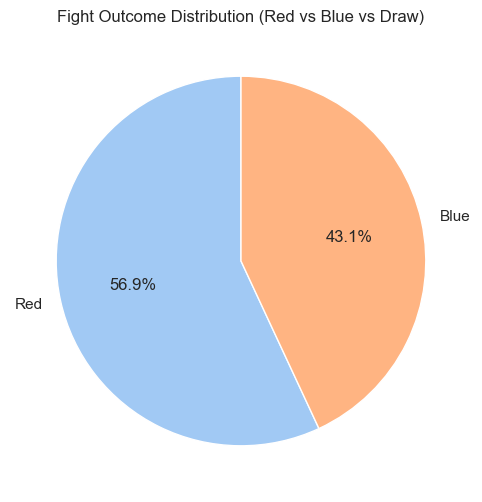

In [147]:
fighter_outcome_count = merged_fighter_stats['who_wins'].value_counts()

plt.figure(figsize=(10, 6))
fighter_outcome_count.plot(kind='pie', autopct='%1.1f%%', startangle=90, colors=sns.color_palette('pastel'))
plt.title("Fight Outcome Distribution (Red vs Blue vs Draw)")
plt.ylabel("")
plt.show()

#### Vis 2: Round-wise Fight Outcomes

<Figure size 1000x600 with 0 Axes>

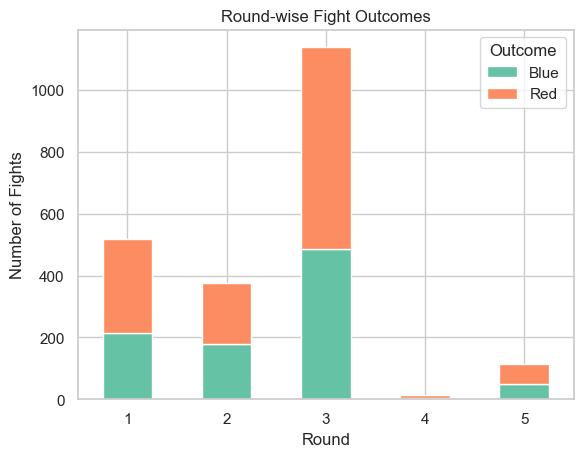

In [175]:
round_outcomes = merged_fighter_stats.groupby(['round', 'who_wins']).size().unstack(fill_value=0)

plt.figure(figsize=(10, 6))
round_outcomes.plot(kind='bar', stacked=True, color=sns.color_palette("Set2"))
plt.title("Round-wise Fight Outcomes")
plt.xlabel("Round")
plt.xticks(rotation=0)
plt.ylabel("Number of Fights")
plt.legend(title="Outcome")
plt.show()

#### Vis 3: Fight Method outcome

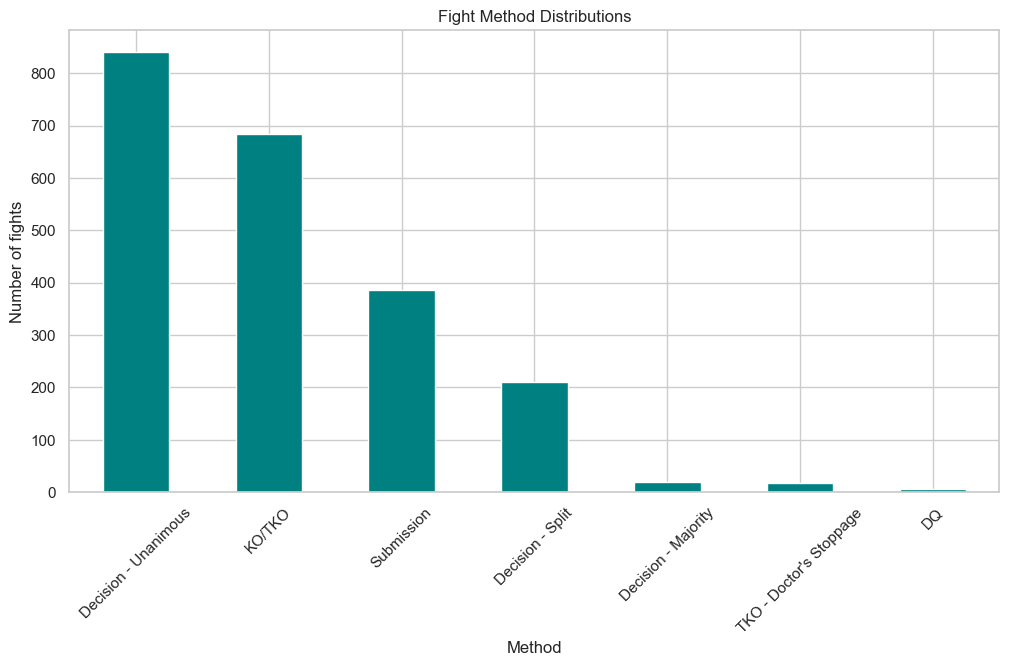

In [149]:
method_counts = merged_fighter_stats['method'].value_counts()

plt.figure(figsize=(12, 6))
method_counts.plot(kind='bar', color='teal')
plt.title('Fight Method Distributions')
plt.xlabel('Method')
plt.ylabel('Number of fights')
plt.xticks(rotation=45)
plt.show()

#### Vis 4:  boxplots for outliers

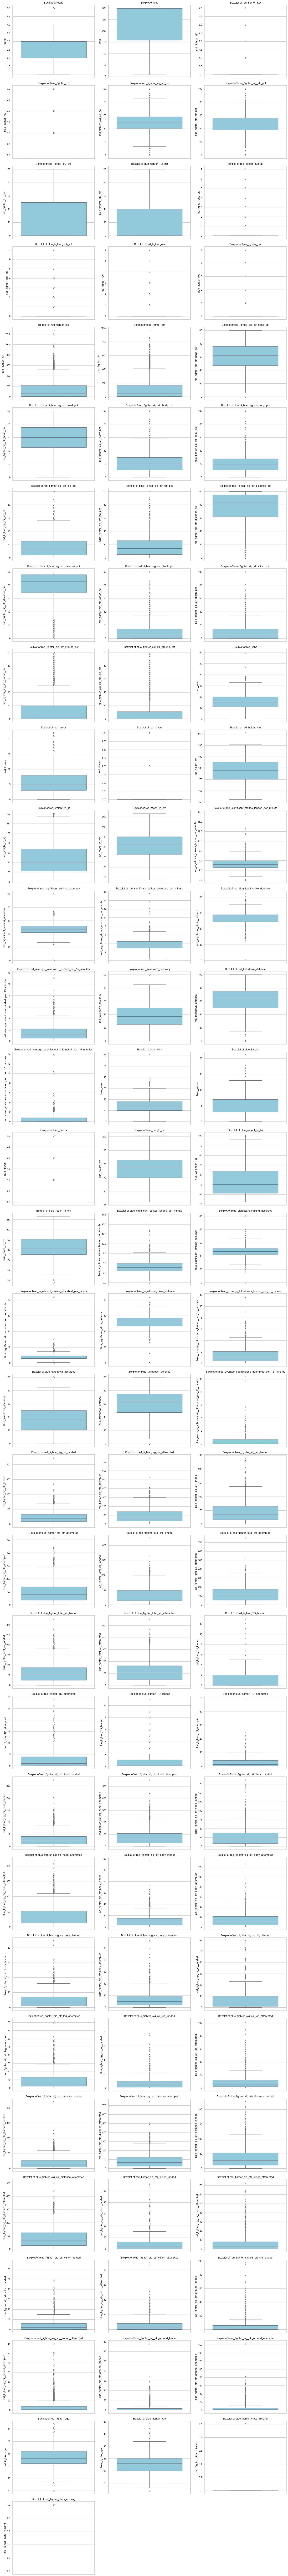

In [150]:

numeric_features = merged_fighter_stats.select_dtypes(include=['float64', 'int64']).columns


num_features = len(numeric_features)
num_rows = (num_features // 3) + (num_features % 3 > 0)  # Calculate number of rows


plt.figure(figsize=(18, num_rows * 5))
for i, feature in enumerate(numeric_features, 1):
    plt.subplot(num_rows, 3, i)
    sns.boxplot(y=merged_fighter_stats[feature], color='skyblue')
    plt.title(f"Boxplot of {feature}")
    plt.xlabel("")

plt.tight_layout()
plt.show()


#### Vis 5: Correlation Heatmap 

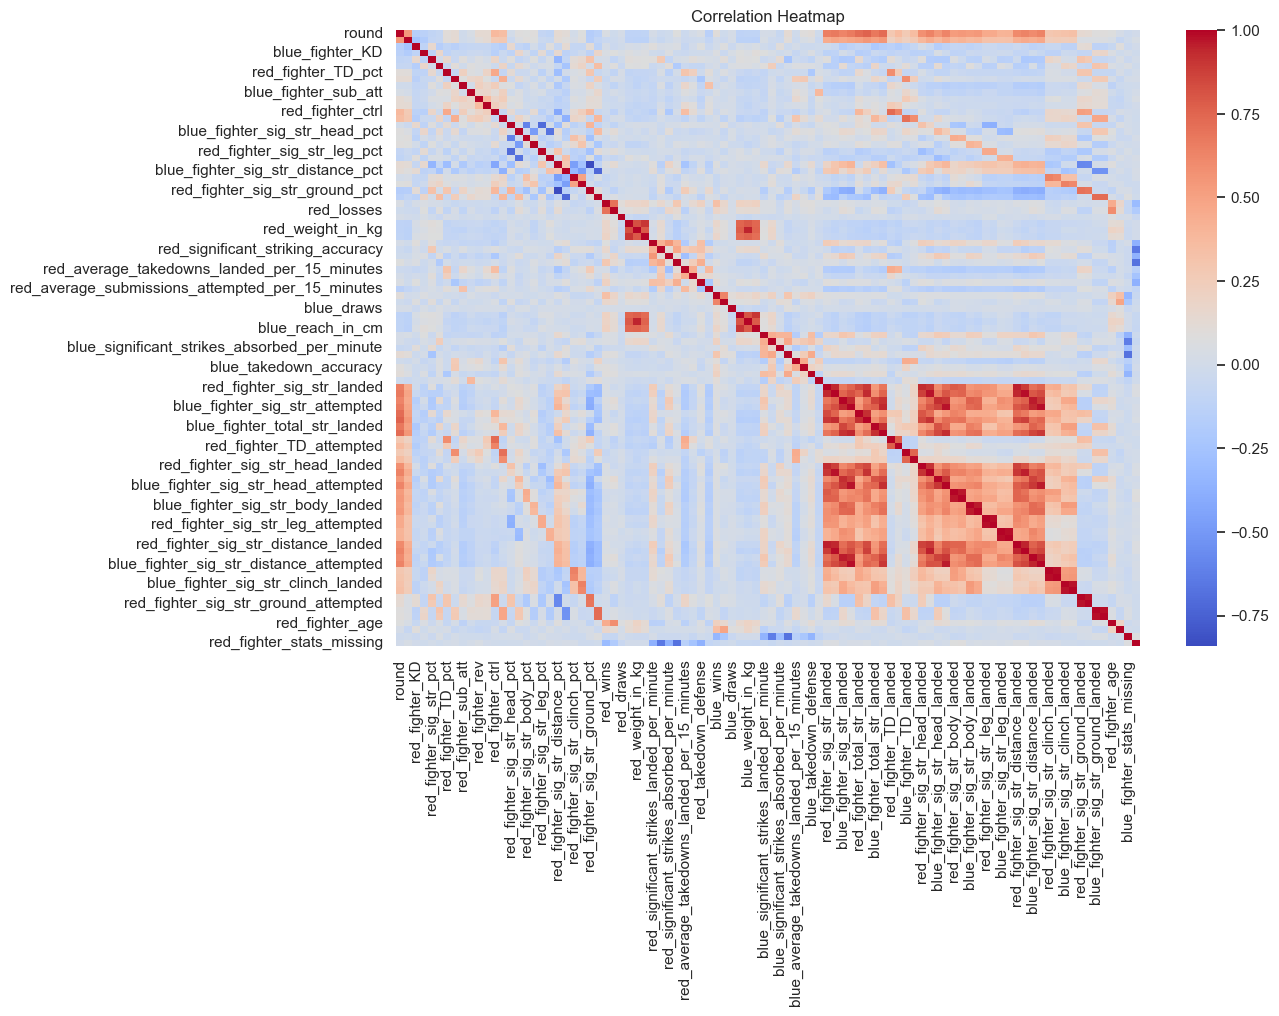

In [151]:
correlation_matrix = merged_fighter_stats.select_dtypes(include=['float64', 'int64', 'Int64']).corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=False)
plt.title("Correlation Heatmap")
plt.show()

We can see that we have highly correlated columns, which we need to extract and show


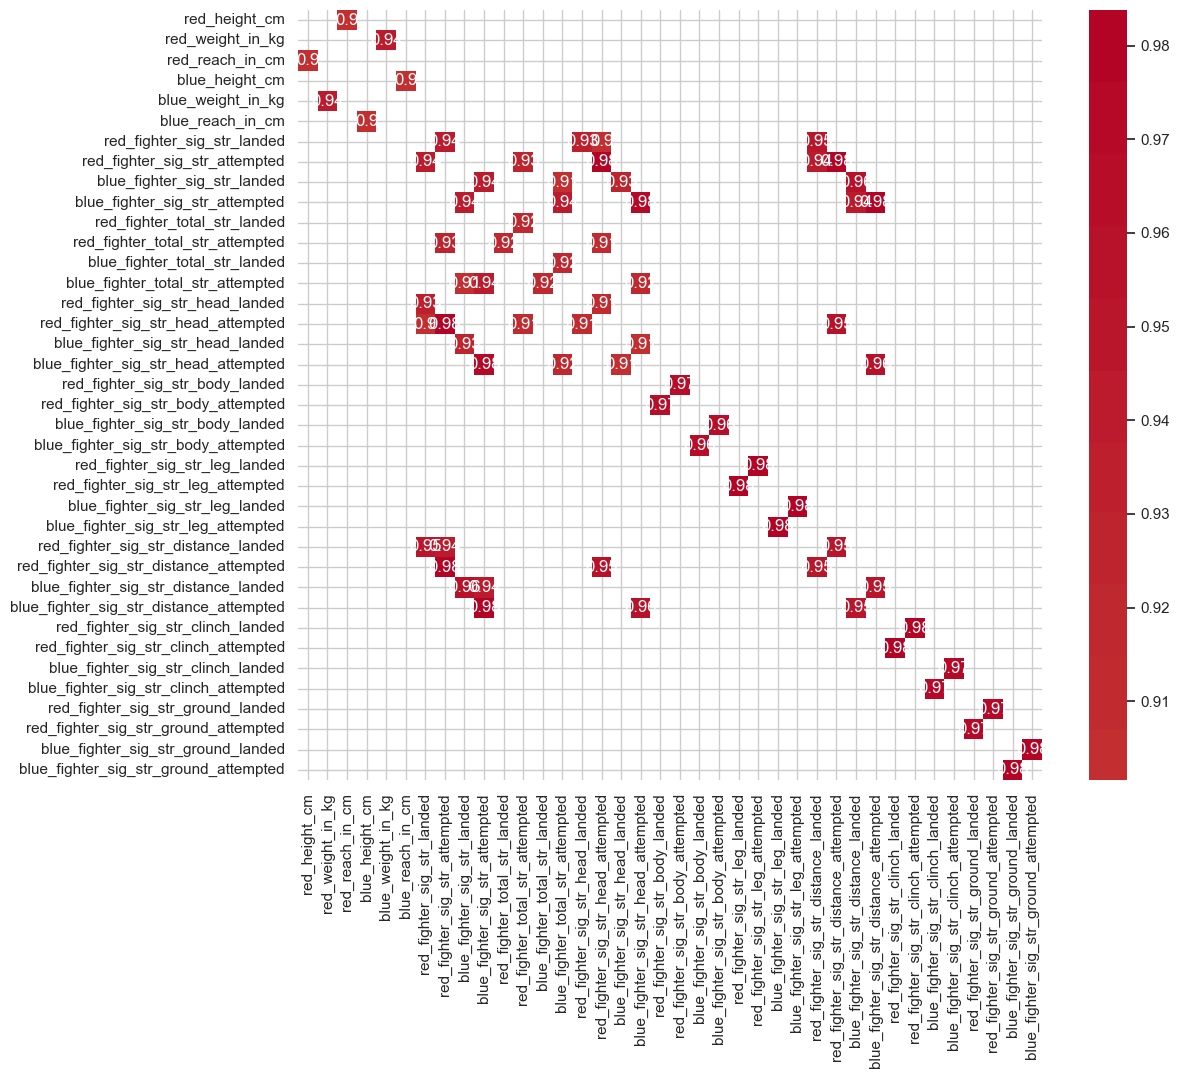

In [152]:
threshold = 0.9

# find correlated columns
filtered_corr_matrix_lrn = correlation_matrix[(correlation_matrix >= threshold) | (correlation_matrix <= -threshold)]

# avoid diagonal of the matrix and get highly correlated  intersections 
np.fill_diagonal(filtered_corr_matrix_lrn.values, np.nan)
filtered_corr_matrix_lrn = filtered_corr_matrix_lrn.dropna(how='all').dropna(axis=1, how='all')

plt.figure(figsize=(12, 10))
sns.heatmap(filtered_corr_matrix_lrn, annot=True, cmap='coolwarm', center=0)
plt.show()

We will remove highly correlated features

In [153]:
def remove_correlated_features(dataset, categorical_features, threshold=0.9):
    corr_matrix = dataset[categorical_features].corr().abs()

    # mask for ignoring self-correlations and it is enough only one triangle, because correlation is symetric
    upper_triangle = np.triu(np.ones(corr_matrix.shape), k=1)
    upper_triangle_matrix = corr_matrix * upper_triangle

    # check which columns we need to drop
    columns_to_drop = [
        column for column in upper_triangle_matrix.columns
        if any(upper_triangle_matrix[column] > threshold)
    ]

    dataset = dataset.drop(columns=columns_to_drop)
    return dataset, columns_to_drop

numerical_features = list(merged_fighter_stats.select_dtypes(include=['float64', 'int64', 'Int64']).columns)
non_correlated_df, correlated_columns = remove_correlated_features(merged_fighter_stats, numeric_features, threshold=0.9)


non_correlated_df

red_fighter_name blue_fighter_name                method  round  time  \
0         ILIA TOPURIA      MAX HOLLOWAY                KO/TKO      3    94   
1     ROBERT WHITTAKER   KHAMZAT CHIMAEV            Submission      1   214   
2     MAGOMED ANKALAEV  ALEKSANDAR RAKIC  Decision - Unanimous      3   300   
3        LERONE MURPHY           DAN IGE  Decision - Unanimous      3   300   
4      SHARA MAGOMEDOV   ARMEN PETROSYAN                KO/TKO      2   292   
...                ...               ...                   ...    ...   ...   
2159     FELICE HERRIG   VIRNA JANDIROBA            Submission      1   104   
2160          TJ BROWN      DANNY CHAVEZ  Decision - Unanimous      3   300   
2161      ASHLEY YODER     LIVINHA SOUZA  Decision - Unanimous      3   300   
2162     CHRIS DAUKAUS     PARKER PORTER                KO/TKO      1   268   
2163        KAI KAMAKA       TONY KELLEY  Decision - Unanimous      3   300   

                         bout_type     bonus  red_fighter_KD  blue_fighter_KD  \
0     UFC Featherweight Title Bout      belt               1                0   
1                Middleweight Bout      perf               0                0   
2           Light Heavyweight Bout  No bonus               0                0   
3               Featherweight Bout  No bonus               0                1   
4                Middleweight Bout      perf               1                0   
...                            ...       ...             ...              ...   
2159      Women's Strawweight Bout      perf               0                0   
2160            Featherweight Bout  No bonus               0                0   
2161      Women's Strawweight Bout  No bonus               0                0   
2162              Heavyweight Bout  No bonus               2                0   
2163            Featherweight Bout     fight               0                0   

      red_fighter_sig_str_pct  blue_fighter_sig_str_pct  red_fighter_TD_pct  \
0                        52.0                      38.0               100.0   
1                       100.0                      75.0                 0.0   
2                        48.0                      45.0                 0.0   
3                        52.0                      43.0                60.0   
4                        61.0                      55.0                 0.0   
...                       ...                       ...                 ...   
2159                    100.0                      80.0                 0.0   
2160                     30.0                      44.0                 0.0   
2161                     28.0                      65.0                 0.0   
2162                     62.0                      32.0                 0.0   
2163                     61.0                      50.0               100.0   

      blue_fighter_TD_pct  red_fighter_sub_att  blue_fighter_sub_att  \
0                     0.0                    0                     0   
1                    50.0                    0                     1   
2                     0.0                    0                     0   
3                    33.0                    0                     0   
4                     0.0                    0                     0   
...                   ...                  ...                   ...   
2159                100.0                    0                     2   
2160                100.0                    0                     0   
2161                 25.0                    0                     0   
2162                  0.0                    0                     0   
2163                  0.0                    0                     0   

      red_fighter_rev  blue_fighter_rev  red_fighter_ctrl  blue_fighter_ctrl  \
0                   0                 0                45                  0   
1                   0                 0                 0                200   
2                   0         

In [154]:
correlated_columns

['red_reach_in_cm',
 'blue_weight_in_kg',
 'blue_reach_in_cm',
 'red_fighter_sig_str_attempted',
 'blue_fighter_sig_str_attempted',
 'red_fighter_total_str_attempted',
 'blue_fighter_total_str_attempted',
 'red_fighter_sig_str_head_landed',
 'red_fighter_sig_str_head_attempted',
 'blue_fighter_sig_str_head_landed',
 'blue_fighter_sig_str_head_attempted',
 'red_fighter_sig_str_body_attempted',
 'blue_fighter_sig_str_body_attempted',
 'red_fighter_sig_str_leg_attempted',
 'blue_fighter_sig_str_leg_attempted',
 'red_fighter_sig_str_distance_landed',
 'red_fighter_sig_str_distance_attempted',
 'blue_fighter_sig_str_distance_landed',
 'blue_fighter_sig_str_distance_attempted',
 'red_fighter_sig_str_clinch_attempted',
 'blue_fighter_sig_str_clinch_attempted',
 'red_fighter_sig_str_ground_attempted',
 'blue_fighter_sig_str_ground_attempted']

## Outliers detection

It is neccessary to detect outliers. We will use interquartile range to detect outliers and prepare function for handling

In [155]:
def detect_outliers(df, feature):
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[feature] < lower_bound) | (df[feature] > upper_bound)]


def count_outliers(df, numerical_features):
    outliers_counter = {}
    for col in numerical_features:
        outliers = detect_outliers(df, col)
        if(len(outliers) > 0):
            outliers_counter[col] = len(outliers)

    df_outliers = pd.DataFrame.from_dict(outliers_counter, orient='index', columns=['Outlier Count'])
    df_outliers.sort_values(by='Outlier Count', ascending=False, inplace=True)

    return df_outliers

# this function applies interquartile range by default. In case there is another values,
# it will clip by using it
def handle_outliers(df, features, upper_quantile=0.75, lower_quantile=0.25):
    for col in features:  
        # in this case apply interquantile range outliers clip[]
        if upper_quantile == 0.75 and lower_quantile == 0.25:
            Q3 = df[col].quantile(upper_quantile)
            Q1 = df[col].quantile(lower_quantile)

            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            df[col] = np.clip(df[col], lower_bound, upper_bound)

        else:
            upper_bound = df[col].quantile(upper_quantile)
            lower_bound = df[col].quantile(lower_quantile)
            
            df[col] = np.clip(df[col], lower_bound, upper_bound)
            
    return df




We will exclude those columns 'round', 'blue_fighter_stats_missing', 'red_fighter_stats_missing' from outliers removal because round is discrete value and all values have same importance. Other two are indeed categorical features which have been already encoded. Time is also important to exclude because it is related to round. We can mix the rounds and times the match has been finished.


In [156]:
# again calculate numerical features because we removed some
columns_to_exclude_outliers = ['round', 'blue_fighter_stats_missing' , 'red_fighter_stats_missing', 'time']
numerical_features = list(non_correlated_df.select_dtypes(include=['float64', 'int64', 'Int64']).drop(columns=columns_to_exclude_outliers).columns)


numerical_features

['red_fighter_KD',
 'blue_fighter_KD',
 'red_fighter_sig_str_pct',
 'blue_fighter_sig_str_pct',
 'red_fighter_TD_pct',
 'blue_fighter_TD_pct',
 'red_fighter_sub_att',
 'blue_fighter_sub_att',
 'red_fighter_rev',
 'blue_fighter_rev',
 'red_fighter_ctrl',
 'blue_fighter_ctrl',
 'red_fighter_sig_str_head_pct',
 'blue_fighter_sig_str_head_pct',
 'red_fighter_sig_str_body_pct',
 'blue_fighter_sig_str_body_pct',
 'red_fighter_sig_str_leg_pct',
 'blue_fighter_sig_str_leg_pct',
 'red_fighter_sig_str_distance_pct',
 'blue_fighter_sig_str_distance_pct',
 'red_fighter_sig_str_clinch_pct',
 'blue_fighter_sig_str_clinch_pct',
 'red_fighter_sig_str_ground_pct',
 'blue_fighter_sig_str_ground_pct',
 'red_wins',
 'red_losses',
 'red_draws',
 'red_height_cm',
 'red_weight_in_kg',
 'red_significant_strikes_landed_per_minute',
 'red_significant_striking_accuracy',
 'red_significant_strikes_absorbed_per_minute',
 'red_significant_strike_defence',
 'red_average_takedowns_landed_per_15_minutes',
 'red_takedo

In [157]:
outliers_sum = count_outliers(non_correlated_df, numerical_features)
outliers_sum

Outlier Count
red_fighter_sub_att                      482
red_fighter_KD                           432
blue_fighter_sub_att                     384
blue_fighter_KD                          355
red_draws                                316
...                                      ...
red_fighter_sig_str_head_pct              38
blue_fighter_total_str_landed             37
red_fighter_total_str_landed              29
blue_fighter_age                          27
red_height_cm                              1

[63 rows x 1 columns]

In [158]:
handled_outliers_df = handle_outliers(non_correlated_df, numerical_features, upper_quantile=0.75, lower_quantile=0.25)
outliers_sum = count_outliers(handled_outliers_df, numerical_features)
outliers_sum

Empty DataFrame
Columns: [Outlier Count]
Index: []

In [159]:
#handled_outliers_df.to_csv(intermediate_steps_folder + 'DS_after_outliers_handling.csv')
handled_outliers_df

red_fighter_name blue_fighter_name                method  round  time  \
0         ILIA TOPURIA      MAX HOLLOWAY                KO/TKO      3    94   
1     ROBERT WHITTAKER   KHAMZAT CHIMAEV            Submission      1   214   
2     MAGOMED ANKALAEV  ALEKSANDAR RAKIC  Decision - Unanimous      3   300   
3        LERONE MURPHY           DAN IGE  Decision - Unanimous      3   300   
4      SHARA MAGOMEDOV   ARMEN PETROSYAN                KO/TKO      2   292   
...                ...               ...                   ...    ...   ...   
2159     FELICE HERRIG   VIRNA JANDIROBA            Submission      1   104   
2160          TJ BROWN      DANNY CHAVEZ  Decision - Unanimous      3   300   
2161      ASHLEY YODER     LIVINHA SOUZA  Decision - Unanimous      3   300   
2162     CHRIS DAUKAUS     PARKER PORTER                KO/TKO      1   268   
2163        KAI KAMAKA       TONY KELLEY  Decision - Unanimous      3   300   

                         bout_type     bonus  red_fighter_KD  blue_fighter_KD  \
0     UFC Featherweight Title Bout      belt               0                0   
1                Middleweight Bout      perf               0                0   
2           Light Heavyweight Bout  No bonus               0                0   
3               Featherweight Bout  No bonus               0                0   
4                Middleweight Bout      perf               0                0   
...                            ...       ...             ...              ...   
2159      Women's Strawweight Bout      perf               0                0   
2160            Featherweight Bout  No bonus               0                0   
2161      Women's Strawweight Bout  No bonus               0                0   
2162              Heavyweight Bout  No bonus               0                0   
2163            Featherweight Bout     fight               0                0   

      red_fighter_sig_str_pct  blue_fighter_sig_str_pct  red_fighter_TD_pct  \
0                        52.0                      38.0               100.0   
1                        85.0                      75.0                 0.0   
2                        48.0                      45.0                 0.0   
3                        52.0                      43.0                60.0   
4                        61.0                      55.0                 0.0   
...                       ...                       ...                 ...   
2159                     85.0                      80.0                 0.0   
2160                     30.0                      44.0                 0.0   
2161                     28.0                      65.0                 0.0   
2162                     62.0                      32.0                 0.0   
2163                     61.0                      50.0               100.0   

      blue_fighter_TD_pct  red_fighter_sub_att  blue_fighter_sub_att  \
0                     0.0                    0                     0   
1                    50.0                    0                     0   
2                     0.0                    0                     0   
3                    33.0                    0                     0   
4                     0.0                    0                     0   
...                   ...                  ...                   ...   
2159                100.0                    0                     0   
2160                100.0                    0                     0   
2161                 25.0                    0                     0   
2162                  0.0                    0                     0   
2163                  0.0                    0                     0   

      red_fighter_rev  blue_fighter_rev  red_fighter_ctrl  blue_fighter_ctrl  \
0                   0                 0              45.0                  0   
1                   0                 0               0.0                200   
2                   0         

## Categorical Label encoding

Before splitting data set into parts, we will encode categorical variables

In [160]:
le = LabelEncoder()

# extract categorical features
categorical_features = list(handled_outliers_df.select_dtypes(include=['object']).columns)


# get a copy of the dataframe
encoded_df = handled_outliers_df.copy()

for feature in categorical_features:
    encoded_df[feature] = le.fit_transform(encoded_df[feature])

#encoded_df.to_csv(intermediate_steps_folder + 'DS_after_encoding.csv')

print(categorical_features)

['red_fighter_name', 'blue_fighter_name', 'method', 'bout_type', 'bonus', 'who_wins']


## Train test split and other scaling transformations

Now, we need to scale features which are skewed or not normaly distributed. Before that we will plot distributions to have a better look of it.

In [161]:
def plot_dataset_histogram(dataset, categorical_features):
    # create plotting df, we exclude categorical columns
    df_for_plot = dataset.drop(columns=categorical_features)

    num_features = len(list(df_for_plot.columns))
    num_rows = (num_features // 3) + (num_features % 3 > 0)  # Calculate number of rows
    plt.figure(figsize=(18, num_rows * 5))
    for i, feature in enumerate(list(df_for_plot.columns), 1):
        plt.subplot(num_rows, 3, i)
        sns.histplot(x=df_for_plot[feature], kde=True, color='green')
        plt.title(f"Boxplot of {feature}")
        plt.xlabel("")

    plt.tight_layout()
    plt.show()



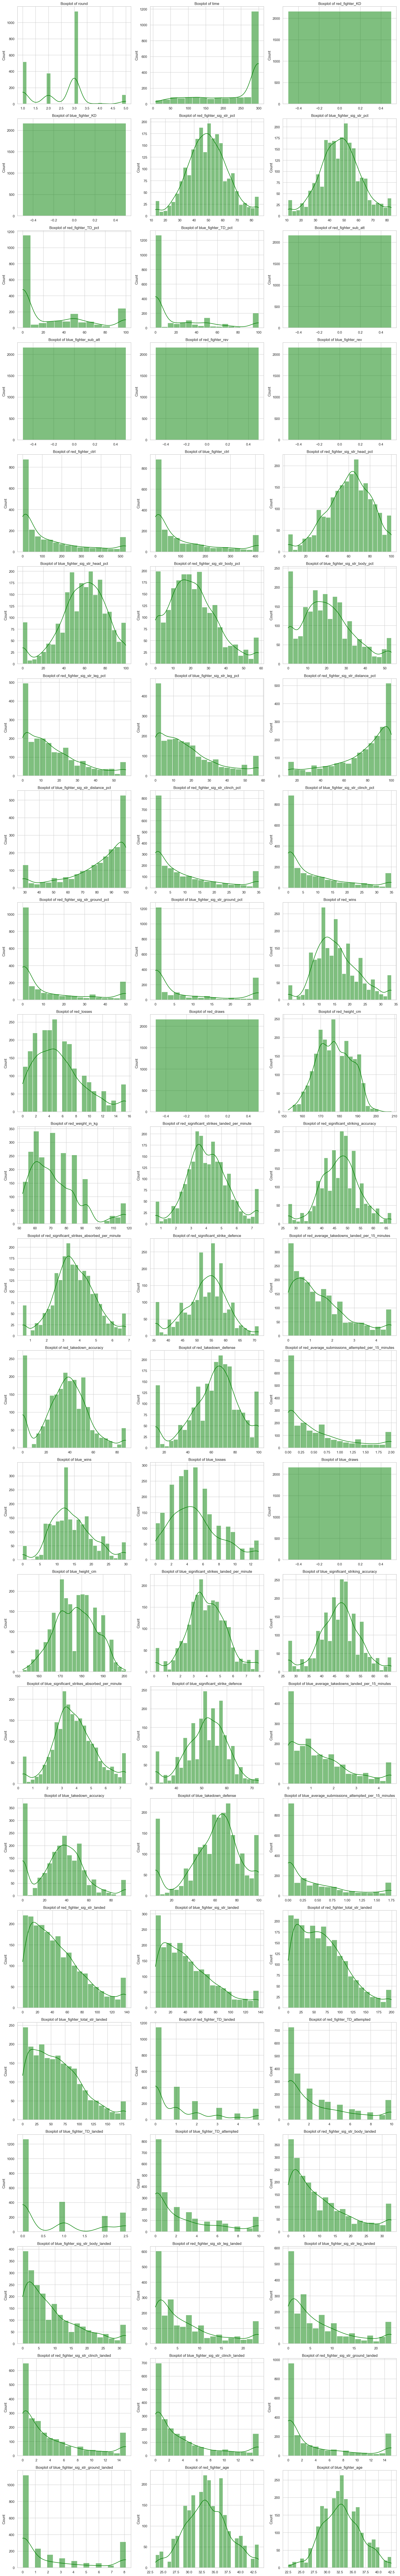

In [162]:
# we need to add missing statistics for blue and red fighter stats, because they are binary categorical values
categorical_features.extend(['blue_fighter_stats_missing', 'red_fighter_stats_missing'])
plot_dataset_histogram(encoded_df, categorical_features)


We will need to detect which are skewed features. We will apply logarithmic transformation. However, firstly we will split dataset

In [163]:
X = encoded_df.drop(columns=['who_wins'])
y = encoded_df['who_wins']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)



Now, we will detect skew features. They will be independently done for train and test


In [164]:
def log_transform(X_train, X_test, skewed_features_train, skewed_features_test):
    X_train[skewed_features_train] = X_train[skewed_features_train].apply(lambda x: np.log1p(x))
    X_test[skewed_features_test] = X_test[skewed_features_test].apply(lambda x: np.log1p(x))
    
    return X_train, X_test

In [165]:
# apply logarithmic function
skewed_features_train = [col for col in X_train.columns if X_train[col].skew() < -1 or X_train[col].skew() > 1]
skewed_features_test = [col for col in X_test.columns if X_test[col].skew() < -1 or X_test[col].skew() > 1]

X_train, X_test = log_transform(X_train, X_test, skewed_features_train=skewed_features_train, skewed_features_test=skewed_features_test)

## First ML testing

In this task, we will use 4 different classifiers, which use different logic for predicting the values. Those are:
- SVM
- Random Forest
- XGBoost
- MLP

Initially we will use default parameters without any data tranformation except logarithmic operation

In [166]:
# initialize ML models
models = {
    "MLP": MLPClassifier(),
    "SVM": SVC(),
    "XGBoost": XGBClassifier(), 
    "RandomForest": RandomForestClassifier()
}

results = {}
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Compute metrics
    results[model_name] = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1 Score": f1_score(y_test, y_pred),
        "Confusion Matrix": confusion_matrix(y_test, y_pred),
        "Classification Report": classification_report(y_test, y_pred)
    }

# Convert results to DataFrame for display
df_results = pd.DataFrame({model: {metric: results[model][metric] for metric in ["Accuracy", "Precision", "Recall", "F1 Score"]} for model in results})

In [167]:
for model_name, result in results.items():
    print("Model: ", model_name)
    print(result['Classification Report'])

Model:  MLP
              precision    recall  f1-score   support

           0       0.90      0.32      0.48       195
           1       0.64      0.97      0.77       238

    accuracy                           0.68       433
   macro avg       0.77      0.65      0.62       433
weighted avg       0.76      0.68      0.64       433

Model:  SVM
              precision    recall  f1-score   support

           0       0.88      0.68      0.77       195
           1       0.78      0.92      0.84       238

    accuracy                           0.81       433
   macro avg       0.83      0.80      0.81       433
weighted avg       0.82      0.81      0.81       433

Model:  XGBoost
              precision    recall  f1-score   support

           0       0.80      0.80      0.80       195
           1       0.84      0.84      0.84       238

    accuracy                           0.82       433
   macro avg       0.82      0.82      0.82       433
weighted avg       0.82      0.82 

Now, we will do scaling and applying k-fold cross valdiation with grid search hyperparameter tuning

In [176]:
# Define scalers
scaler_standard = StandardScaler()
scaler_minmax = MinMaxScaler()

# Define classifiers and hyperparameter grids
models = {
    "RandomForest": (RandomForestClassifier(), {"n_estimators": [50, 100], "max_depth": [None, 10]}),
    # SVM takes a lot of time toe xecute, so we executed it once and remember the results 
    # in the chunk below
    #"SVM": (SVC(), {"C": [0.1, 1, 10], "kernel": ["linear", 'rbf']}), 
    "XGBoost": (XGBClassifier(), {"n_estimators": [50, 100], "learning_rate": [0.01, 0.1]}),
    "MLP": (MLPClassifier(), {"hidden_layer_sizes": [(50,), (100,)], "alpha": [0.0001, 0.001]})
}

# Scaling combinations
scaling_methods = {
    "No Scaling": lambda X: X,
    "Standard Scaling": lambda X: scaler_standard.fit_transform(X),
    "MinMax Scaling": lambda X: scaler_minmax.fit_transform(X)
}

# Perform k-fold cross-validation with hyperparameter tuning
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for model_name, (model, param_grid) in models.items():
    for scaling_name, scaling_function in scaling_methods.items():
        print(f"Training {model_name} with {scaling_name}...")
        
        # Apply scaling
        X_scaled = scaling_function(X)
        
        grid_search = GridSearchCV(model, param_grid, cv=kf, scoring='accuracy', n_jobs=-1)
        grid_search.fit(X_scaled, y)
        
        print(f"Best parameters for {model_name} ({scaling_name}): {grid_search.best_params_}")
        print(f"Best accuracy for {model_name} ({scaling_name}): {grid_search.best_score_}\n")


Training RandomForest with No Scaling...
Best parameters for RandomForest (No Scaling): {'max_depth': 10, 'n_estimators': 100}
Best accuracy for RandomForest (No Scaling): 0.8438104097168763

Training RandomForest with Standard Scaling...
Best parameters for RandomForest (Standard Scaling): {'max_depth': 10, 'n_estimators': 100}
Best accuracy for RandomForest (Standard Scaling): 0.8364169018903429

Training RandomForest with MinMax Scaling...
Best parameters for RandomForest (MinMax Scaling): {'max_depth': None, 'n_estimators': 100}
Best accuracy for RandomForest (MinMax Scaling): 0.840572876571722

Training XGBoost with No Scaling...
Best parameters for XGBoost (No Scaling): {'learning_rate': 0.1, 'n_estimators': 100}
Best accuracy for XGBoost (No Scaling): 0.8502844068086564

Training XGBoost with Standard Scaling...
Best parameters for XGBoost (Standard Scaling): {'learning_rate': 0.1, 'n_estimators': 100}
Best accuracy for XGBoost (Standard Scaling): 0.8502844068086564

Training XG

This is output with SVM. We will remember this because we don't want to repeat SVM because it takes 41 min to execute all combinations

Training RandomForest with No Scaling...
Best parameters for RandomForest (No Scaling): {'max_depth': None, 'n_estimators': 100}
Best accuracy for RandomForest (No Scaling): 0.8382666153451372

Training RandomForest with Standard Scaling...
Best parameters for RandomForest (Standard Scaling): {'max_depth': 10, 'n_estimators': 100}
Best accuracy for RandomForest (Standard Scaling): 0.842881276195364

Training RandomForest with MinMax Scaling...
Best parameters for RandomForest (MinMax Scaling): {'max_depth': None, 'n_estimators': 100}
Best accuracy for RandomForest (MinMax Scaling): 0.8410358395346847

Training SVM with No Scaling...
Best parameters for SVM (No Scaling): {'C': 1, 'kernel': 'linear'}
Best accuracy for SVM (No Scaling): 0.8553652382174322

Training SVM with Standard Scaling...
Best parameters for SVM (Standard Scaling): {'C': 0.1, 'kernel': 'linear'}
Best accuracy for SVM (Standard Scaling): 0.8572170900692841

Training SVM with MinMax Scaling...
Best parameters for SVM (MinMax Scaling): {'C': 1, 'kernel': 'linear'}
Best accuracy for SVM (MinMax Scaling): 0.8558303395774528

Training XGBoost with No Scaling...
Best parameters for XGBoost (No Scaling): {'learning_rate': 0.1, 'n_estimators': 100}
Best accuracy for XGBoost (No Scaling): 0.8502844068086564

Training XGBoost with Standard Scaling...
Best parameters for XGBoost (Standard Scaling): {'learning_rate': 0.1, 'n_estimators': 100}
Best accuracy for XGBoost (Standard Scaling): 0.8502844068086564

Training XGBoost with MinMax Scaling...
Best parameters for XGBoost (MinMax Scaling): {'learning_rate': 0.1, 'n_estimators': 100}
Best accuracy for XGBoost (MinMax Scaling): 0.8502844068086564

Training MLP with No Scaling...
Best parameters for MLP (No Scaling): {'alpha': 0.0001, 'hidden_layer_sizes': (50,)}
Best accuracy for MLP (No Scaling): 0.8202367205542724

Training MLP with Standard Scaling...
Best parameters for MLP (Standard Scaling): {'alpha': 0.001, 'hidden_layer_sizes': (100,)}
Best accuracy for MLP (Standard Scaling): 0.8364211786844582

Training MLP with MinMax Scaling...
Best parameters for MLP (MinMax Scaling): {'alpha': 0.0001, 'hidden_layer_sizes': (100,)}
Best accuracy for MLP (MinMax Scaling): 0.8498182362501069

#### Output analysis
From the output above, we can extract information:

Random Forest<br/>
No Scaling -> 0.83826 <br/>
Standard Scaling -> 0.84288 -> The best<br/>
MinMax -> 0.84103<br/>

SVM <br/>
No Scaling -> 0.85536<br/>
Standard Scaling -> 0.85721 -> The best<br/>
MinMax Scaling -> 0.85583<br/>

XGBoost <br/>
No Scaling -> 0.85028<br/>
Standard Scaling -> 0.85028<br/>
MinMax Scaling -> 0.85028 <br/>
For all accuracy is same, so it doesn't matter

MLP<br/>
No Scaling -> 0.82023<br/>
Standard Scaling -> 0.83642<br/>
MinMax Scaling -> 0.84981 -> The best<br/>
 
Using accuracy as main metric, we can conclude that the best algorithm is SVM, with scaled features and parameters:
{'C': 0.1, 'kernel': 'linear'}

We will use it for the final prediction


In [177]:
# define hyperparameters
c = 0.1
kernel = 'linear'

scaler = StandardScaler()

# apply standard scaler
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = SVC(C=c, kernel=kernel)

model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)

results = {
    "Metric": ["Accuracy", "Precision", "Recall", "F1 Score"],
    "Value": [
        accuracy_score(y_test, y_pred),
        precision_score(y_test, y_pred),
        recall_score(y_test, y_pred),
        f1_score(y_test, y_pred)
    ]
}

# Convert dictionary to Pandas DataFrame
df_results = pd.DataFrame(results)

df_results

Metric     Value
0   Accuracy  0.702079
1  Precision  0.965812
2     Recall  0.474790
3   F1 Score  0.636620

In [170]:
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[191   4]
 [125 113]]


In [171]:
classification_report = classification_report(y_test, y_pred)
print(classification_report)

              precision    recall  f1-score   support

           0       0.60      0.98      0.75       195
           1       0.97      0.47      0.64       238

    accuracy                           0.70       433
   macro avg       0.79      0.73      0.69       433
weighted avg       0.80      0.70      0.69       433



However, the last result is not so good, accuracy is 70%. It is expected because this model almost cannot be used in reality because of a lot of reasons.
(Here need to write more things)

## Summary